In [214]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

In [215]:
# Patch A: Limit BLAS/MKL/OpenMP threads to avoid thread creation errors on limited VMs
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OPENBLAS_MT"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
# Optional: set this early (before numpy/scipy import)
print("Set BLAS/MKL thread limits to 1 to avoid resource exhaustion.")


Set BLAS/MKL thread limits to 1 to avoid resource exhaustion.


In [216]:
from shapely import wkt
def safe_parse_point(point_wkt):
    import re
    import numpy as np
    if pd.isna(point_wkt) or point_wkt is None:
        return (np.nan, np.nan)
    try:
        p = wkt.loads(point_wkt)
        return (p.y, p.x)
    except Exception:
        m = re.search(r"POINT\s*\(([0-9\-\.\+]+)\s+([0-9\-\.\+]+)\)", str(point_wkt))
        if m:
            lon = float(m.group(1)); lat = float(m.group(2))
            return (lat, lon)
        return (np.nan, np.nan)


In [217]:
# Patch B: Robust data loader - replace old hardcoded path
import os
import pandas as pd

# Preferred path inside this environment
DATA_PATH = '/mnt/data/Electric_Vehicle_Population_Data.csv'   # change if needed
if not os.path.exists(DATA_PATH):
    # try a few alternatives
    candidates = [
        '/mnt/data/ev_feature_engineered.csv',
        '/mnt/data/ev_registration_cleaned.csv',
        '/mnt/data/EV.csv',
        './Electric_Vehicle_Population_Data.csv'
    ]
    found = next((p for p in candidates if os.path.exists(p)), None)
    if found:
        DATA_PATH = found

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found. Place your dataset at {DATA_PATH} or change DATA_PATH.")

print("Loading dataset from:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded shape:", df.shape)


Loading dataset from: /mnt/data/ev_registration_cleaned.csv
Loaded shape: (223995, 48)


In [218]:
# Display all columns in outputs
pd.set_option('display.max_columns', None)

In [219]:
# View first few rows
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,vin_1_10,county,city,state,postal_code,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,electric_utility,2020_census_tract,model_norm,make_norm,base_msrp_outlier,base_msrp_capped,electric_range_outlier,electric_range_capped,latitude,longitude,geo_cluster,vehicle_age,is_new,price_per_mile,range_group,price_bucket,is_popular_make,vehicle_family,is_bev,is_phev,cafv_encoded,utility_encoded,state_adoption_score,age_x_range,make_x_year,range_high,range_low,range_medium,range_premium,price_economy,price_mid,price_premium,make_x_year_enc,make_top
0,1C4JJXP66P,Kitsap,Poulsbo,WA,98370.0,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0.0,23.0,258127145,PUGET SOUND ENERGY INC,5.303509e+10,WRANGLER,JEEP,False,0.0,False,21,47.73689,-122.64681,3,2,0,0.0,LOW,ECONOMY,1,JEEP WRANGLER,0,0,NaN,73,0.997884,42,JEEP_2023,False,True,False,False,True,False,False,116,JEEP
1,1G1FX6S08K,Snohomish,Lake Stevens,WA,98258.0,2019,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0.0,44.0,4735426,PUGET SOUND ENERGY INC,5.306105e+10,BOLT EV,CHEVROLET,False,0.0,True,238,48.01497,-122.06402,3,6,0,0.0,HIGH,ECONOMY,1,CHEVROLET BOLT EV,0,0,NaN,73,0.997884,1428,CHEVROLET_2019,True,False,False,False,True,False,False,47,CHEVROLET
2,WBY1Z2C58F,King,Seattle,WA,98116.0,2015,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,0.0,34.0,272697666,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,I3,BMW,False,0.0,False,81,47.57894,-122.41067,3,10,0,0.0,LOW,ECONOMY,1,BMW I3,0,0,NaN,57,0.997884,810,BMW_2015,False,True,False,False,True,False,False,19,BMW
3,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0.0,37.0,477309682,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,MODEL 3,TESLA,False,0.0,True,220,47.49461,-122.23825,3,6,0,0.0,HIGH,ECONOMY,1,TESLA MODEL 3,0,0,NaN,57,0.997884,1320,TESLA_2019,True,False,False,False,True,False,False,244,TESLA
4,5YJSA1V24F,Yakima,Selah,WA,98942.0,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,0.0,15.0,258112970,PACIFICORP,5.307700e+10,MODEL S,TESLA,False,0.0,True,208,46.65405,-120.53145,4,10,0,0.0,HIGH,ECONOMY,1,TESLA MODEL S,0,0,NaN,65,0.997884,2080,TESLA_2015,True,False,False,False,True,False,False,240,TESLA


In [220]:
# reading of last 5 rows
print("Last 5 rows of the dataset:")
display(df.tail())

Last 5 rows of the dataset:


,vin_1_10,county,city,state,postal_code,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,electric_utility,2020_census_tract,model_norm,make_norm,base_msrp_outlier,base_msrp_capped,electric_range_outlier,electric_range_capped,latitude,longitude,geo_cluster,vehicle_age,is_new,price_per_mile,range_group,price_bucket,is_popular_make,vehicle_family,is_bev,is_phev,cafv_encoded,utility_encoded,state_adoption_score,age_x_range,make_x_year,range_high,range_low,range_medium,range_premium,price_economy,price_mid,price_premium,make_x_year_enc,make_top
223990,7SAYGDEE4R,Pierce,Puyallup,WA,98374.0,2024,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0.0,2.0,264662359,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.305307e+10,MODEL Y,TESLA,False,0.0,False,0,47.13959,-122.27575,0,1,1,0.0,LOW,ECONOMY,1,TESLA MODEL Y,0,0,NaN,74,0.997884,0,TESLA_2024,False,True,False,False,True,False,False,249,TESLA
223991,WBY8P2C00M,Snohomish,Lake Stevens,WA,98258.0,2021,BMW,I3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0.0,44.0,157728168,PUGET SOUND ENERGY INC,5.306105e+10,I3,BMW,False,0.0,False,0,48.01497,-122.06402,3,4,0,0.0,LOW,ECONOMY,1,BMW I3,0,0,NaN,73,0.997884,0,BMW_2021,False,True,False,False,True,False,False,25,BMW
223992,JN1AZ0CP3B,Pierce,University Place,WA,98466.0,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0.0,28.0,261733433,BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,5.305307e+10,LEAF,NISSAN,False,0.0,False,73,47.23165,-122.53756,0,14,0,0.0,LOW,ECONOMY,1,NISSAN LEAF,0,0,NaN,19,0.997884,1022,NISSAN_2011,False,True,False,False,True,False,False,186,NISSAN
223993,5YJ3E1EA2R,Pierce,Puyallup,WA,98374.0,2024,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0.0,25.0,275283487,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.305307e+10,MODEL 3,TESLA,False,0.0,False,0,47.13959,-122.27575,0,1,1,0.0,LOW,ECONOMY,1,TESLA MODEL 3,0,0,NaN,74,0.997884,0,TESLA_2024,False,True,False,False,True,False,False,249,TESLA
223994,WBY8P8C57K,King,Woodinville,WA,98072.0,2019,BMW,I3,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,126,0.0,45.0,267288801,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,I3,BMW,False,0.0,True,126,47.75448,-122.15545,3,6,0,0.0,MEDIUM,ECONOMY,1,BMW I3,0,0,NaN,74,0.997884,756,BMW_2019,False,False,True,False,True,False,False,23,BMW


In [221]:
# Check shape (rows, columns)
print(f"\nDataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset contains 223995 rows and 48 columns.


In [222]:
# Cell B: Normalize column names (title-case -> snake_case)
import re

def to_snake(s):
    if s is None: return s
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)                 # collapse spaces
    s = re.sub(r'[^0-9a-zA-Z]+', '_', s)       # replace non-alnum with underscore
    s = re.sub(r'__+', '_', s)                 # collapse multiple underscores
    return s.strip('_').lower()

col_map = {c: to_snake(c) for c in df.columns}
df.rename(columns=col_map, inplace=True)

print("Renamed columns to snake_case. Sample columns:")
print(df.columns.tolist()[:40])
# Quick checks: show that key columns exist
for expected in ['vin','electric_range','base_msrp','vehicle_location','model_year']:
    print(expected, "present?" , expected in df.columns)


Renamed columns to snake_case. Sample columns:
['vin_1_10', 'county', 'city', 'state', 'postal_code', 'model_year', 'make', 'model', 'electric_vehicle_type', 'clean_alternative_fuel_vehicle_cafv_eligibility', 'electric_range', 'base_msrp', 'legislative_district', 'dol_vehicle_id', 'electric_utility', '2020_census_tract', 'model_norm', 'make_norm', 'base_msrp_outlier', 'base_msrp_capped', 'electric_range_outlier', 'electric_range_capped', 'latitude', 'longitude', 'geo_cluster', 'vehicle_age', 'is_new', 'price_per_mile', 'range_group', 'price_bucket', 'is_popular_make', 'vehicle_family', 'is_bev', 'is_phev', 'cafv_encoded', 'utility_encoded', 'state_adoption_score', 'age_x_range', 'make_x_year', 'range_high']
vin present? False
electric_range present? True
base_msrp present? True
vehicle_location present? False
model_year present? True


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223995 entries, 0 to 223994
Data columns (total 48 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   vin_1_10                                         223995 non-null  object 
 1   county                                           223995 non-null  object 
 2   city                                             223995 non-null  object 
 3   state                                            223995 non-null  object 
 4   postal_code                                      223995 non-null  float64
 5   model_year                                       223995 non-null  int64  
 6   make                                             223995 non-null  object 
 7   model                                            223995 non-null  object 
 8   electric_vehicle_type                            223995 non-null  object 
 9   clean_alternati

In [224]:
# Check data types before data cleaning
print("\nData Types of Columns:")
print(df.dtypes)


Data Types of Columns:
vin_1_10                                            object
county                                              object
city                                                object
state                                               object
postal_code                                        float64
model_year                                           int64
make                                                object
model                                               object
electric_vehicle_type                               object
clean_alternative_fuel_vehicle_cafv_eligibility     object
electric_range                                       int64
base_msrp                                          float64
legislative_district                               float64
dol_vehicle_id                                       int64
electric_utility                                    object
2020_census_tract                                  float64
model_norm                      

In [225]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
vin_1_10                                                0
county                                                  0
city                                                    0
state                                                   0
postal_code                                             0
model_year                                              0
make                                                    0
model                                                   0
electric_vehicle_type                                   0
clean_alternative_fuel_vehicle_cafv_eligibility         0
electric_range                                          0
base_msrp                                               0
legislative_district                                    0
dol_vehicle_id                                          0
electric_utility                                        0
2020_census_tract                                       0
model_norm                                  

In [226]:
# Cell 16: Deduplicate rows, validate VINs, drop trivial columns if desired
# Remove exact duplicate rows
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Rows before drop_duplicates: {initial_rows}, after: {len(df)}")

# If VIN is available, keep first occurrence of each VIN (assumes VIN uniquely identifies vehicle)
if 'vin' in df.columns:
    before_vin = len(df)
    df = df.sort_values(by=['model_year'], ascending=False).drop_duplicates(subset=['vin'], keep='first').reset_index(drop=True)
    print(f"Rows before VIN dedup: {before_vin}, after VIN dedup: {len(df)}")

# Remove rows with clearly invalid or missing VINs (optional)
if 'vin' in df.columns:
    def valid_vin(v):
        if v is None: return False
        v = str(v).strip()
        # Basic check: VINs are typically 17 chars; your dataset stores first 10 characters, so require length >= 8
        return len(v) >= 8 and all(ch.isalnum() for ch in v)
    bad_vin_count = df[~df['vin'].apply(valid_vin)].shape[0]
    print("Bad/short VIN count:", bad_vin_count)
    # Optionally drop them:
    # df = df[df['vin'].apply(valid_vin)].reset_index(drop=True)

# Drop columns that are purely duplicates or not needed
# Example: if 'vehicle_location' retained lat/lon, you may drop the original geometry WKT to reduce size
if 'vehicle_location' in df.columns and 'latitude' in df.columns and 'longitude' in df.columns:
    # keep geometry only if you need it; otherwise drop to reduce file size
    df.drop(columns=['vehicle_location'], inplace=True, errors='ignore')
    print("Dropped original 'vehicle_location' column (lat/lon present).")


Rows before drop_duplicates: 223995, after: 223995


In [227]:
# Cell 17: Normalize model strings (remove excessive spaces, unify common variants)
def normalize_model_name(s):
    if s is None:
        return None
    s = str(s).strip()
    # remove duplicate white spaces
    s = re.sub(r'\s+', ' ', s)
    # common normalizations (expand as needed)
    s = s.upper()
    s = s.replace('MODEL ', 'MODEL ').replace(' -', '-')  # placeholder for ad-hoc fixes
    # fix known oddities: MODEL3 -> MODEL 3, MODELY -> MODEL Y, if appear
    s = re.sub(r'MODEL(\s?)(3)', r'MODEL 3', s)
    s = re.sub(r'MODEL(\s?)(Y)', r'MODEL Y', s)
    # strip trailing punctuation
    s = s.strip('-_ .')
    return s

if 'model' in df.columns:
    df['model_norm'] = df['model'].apply(normalize_model_name)
    print("Sample normalized models:")
    display(df[['model','model_norm']].drop_duplicates().head(10))

if 'make' in df.columns:
    # Upper-case makes and trim
    df['make_norm'] = df['make'].apply(lambda x: str(x).strip().upper() if x is not None else None)
    print("Sample normalized makes:")
    display(df['make_norm'].value_counts().head(10))


Sample normalized models:


,model,model_norm
0,WRANGLER,WRANGLER
1,BOLT EV,BOLT EV
2,I3,I3
3,MODEL 3,MODEL 3
4,MODEL S,MODEL S
6,530E,530E
7,MODEL X,MODEL X
10,LEAF,LEAF
11,RZ,RZ
12,EV6,EV6


Sample normalized makes:


make_norm
TESLA        96180
CHEVROLET    16405
NISSAN       15259
FORD         11930
KIA          10760
BMW           9171
TOYOTA        8956
HYUNDAI       6878
RIVIAN        6236
JEEP          5773
Name: count, dtype: int64

In [228]:
# Cell 18: Outlier detection using IQR and optional capping
def flag_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

# For base_msrp
if 'base_msrp' in df.columns:
    msrp_series = df['base_msrp'].dropna()
    if len(msrp_series) > 0:
        lower, upper = flag_outliers_iqr(msrp_series)
        print(f"MSRP IQR bounds: lower={lower}, upper={upper}")
        df['base_msrp_outlier'] = df['base_msrp'].apply(lambda x: False if pd.isna(x) else (x < lower or x > upper))
        print("MSRP outlier count:", df['base_msrp_outlier'].sum())
        # Optionally cap outliers to nearest bound
        df['base_msrp_capped'] = df['base_msrp']
        df.loc[df['base_msrp_capped'] > upper, 'base_msrp_capped'] = upper
        df.loc[df['base_msrp_capped'] < lower, 'base_msrp_capped'] = lower

# For electric_range
if 'electric_range' in df.columns:
    er_series = df['electric_range'].dropna().astype(float)
    if len(er_series) > 0:
        lower_er, upper_er = flag_outliers_iqr(er_series)
        print(f"E-Range IQR bounds: lower={lower_er}, upper={upper_er}")
        df['electric_range_outlier'] = df['electric_range'].apply(lambda x: False if pd.isna(x) else (x < lower_er or x > upper_er))
        print("Electric range outlier count:", df['electric_range_outlier'].sum())
        # Optionally cap range outliers
        df['electric_range_capped'] = df['electric_range']
        df.loc[df['electric_range_capped'] > upper_er, 'electric_range_capped'] = upper_er
        df.loc[df['electric_range_capped'] < lower_er, 'electric_range_capped'] = lower_er


MSRP IQR bounds: lower=0.0, upper=0.0
MSRP outlier count: 3260
E-Range IQR bounds: lower=-58.5, upper=97.5
Electric range outlier count: 37715


In [229]:
# Cell D: KNN imputation (numeric), builds numeric_cols safely
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# Build numeric column list only from columns present
numeric_candidates = ['electric_range','base_msrp','model_year','latitude','longitude']
numeric_cols = [c for c in numeric_candidates if c in df.columns]

print("Numeric cols found for imputation:", numeric_cols)

# Optionally include simple encoded categorical features to help KNN (if present)
cat_for_impute = [c for c in ['make','model','county'] if c in df.columns]

# Build impute_df
impute_df = df[numeric_cols].copy()

# Add ordinal encodings of categorical helpers if present
encoders = {}
for c in cat_for_impute:
    tmp = df[[c]].fillna('___MISSING___').astype(str)
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    enc.fit(tmp)
    encoders[c] = enc
    impute_df[c] = enc.transform(tmp)

if impute_df.shape[1] == 0:
    print("No numeric columns to impute. Skipping KNN imputer.")
else:
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputed_arr = imputer.fit_transform(impute_df)
    imputed_df = pd.DataFrame(imputed_arr, columns=impute_df.columns, index=df.index)
    # restore numeric columns
    for c in numeric_cols:
        if c in imputed_df.columns:
            if c == 'electric_range' or c == 'model_year':
                # round to integers where appropriate and use pandas nullable Int64
                df[c] = imputed_df[c].round().astype('Int64')
            else:
                df[c] = imputed_df[c]
    print("Imputation completed. Missing counts (post-impute):")
    display(df[numeric_cols].isna().sum())


Numeric cols found for imputation: ['electric_range', 'base_msrp', 'model_year', 'latitude', 'longitude']
Imputation completed. Missing counts (post-impute):


electric_range    0
base_msrp         0
model_year        0
latitude          0
longitude         0
dtype: int64

In [230]:
# Cell E: Safe fillna fallback for remaining missing values (avoid filling ID columns)
import numpy as np

# Columns to protect (do not impute)
protect_cols = set(['vin','dol_vehicle_id'])

# Numeric fill: median for numeric columns (except protected)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    if col in protect_cols: 
        continue
    if df[col].isnull().any():
        med = df[col].median(skipna=True)
        if not np.isnan(med):
            df[col].fillna(med, inplace=True)

# Categorical/text fill: mode if exists else 'UNKNOWN'
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols:
    if col in protect_cols:
        continue
    if df[col].isnull().any():
        modes = df[col].mode(dropna=True)
        if not modes.empty:
            df[col].fillna(modes[0], inplace=True)
        else:
            df[col].fillna('UNKNOWN', inplace=True)

print("fillna fallback applied. Remaining missing counts (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))


fillna fallback applied. Remaining missing counts (top 20):


cafv_encoded            223995
vin_1_10                     0
county                       0
is_new                       0
price_per_mile               0
range_group                  0
price_bucket                 0
is_popular_make              0
vehicle_family               0
is_bev                       0
is_phev                      0
utility_encoded              0
state_adoption_score         0
age_x_range                  0
make_x_year                  0
range_high                   0
range_low                    0
range_medium                 0
range_premium                0
price_economy                0
dtype: int64

In [231]:
# Patch D: Vectorized make/model cleanup
if 'model' in df.columns:
    df['model'] = df['model'].astype(str).str.strip().str.upper().str.replace(r'\s+', ' ', regex=True)
if 'make' in df.columns:
    df['make'] = df['make'].astype(str).str.strip().str.upper()


In [232]:
# Cell F: Deduplicate, normalize make/model, cap outliers, and save cleaned dataset
import numpy as np
# 1) Remove exact duplicates and VIN duplicates (keep latest model_year if present)
initial_count = len(df)
df = df.drop_duplicates()
if 'vin' in df.columns:
    if 'model_year' in df.columns:
        df = df.sort_values(by=['model_year'], ascending=False).drop_duplicates(subset=['vin'], keep='first')
    else:
        df = df.drop_duplicates(subset=['vin'], keep='first')
print(f"Removed duplicates: {initial_count} -> {len(df)}")

# 2) Normalize make/model to uppercase trimmed strings
for c in ['make','model']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.upper().replace({'NONE':'UNKNOWN'})

# 3) Outlier capping at 1st/99th percentiles for price/range
for col in ['base_msrp','electric_range']:
    if col in df.columns:
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[col + '_capped'] = df[col]
        df.loc[df[col] < q_low, col + '_capped'] = q_low
        df.loc[df[col] > q_high, col + '_capped'] = q_high
        print(f"{col}: capped to [{q_low}, {q_high}]")

# 4) Save cleaned dataset
OUT_CSV = r'C:\Users\HP\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_registration_cleaned.csv'
OUT_PARQUET = r'C:\Users\HP\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_registration_cleaned.parquet'
df.to_csv(OUT_CSV, index=False)
try:
    df.to_parquet(OUT_PARQUET, index=False)
    print("Saved parquet:", OUT_PARQUET)
except Exception as e:
    print("Parquet save failed (pyarrow/fastparquet not installed?)", e)
print("Saved cleaned csv:", OUT_CSV)


Removed duplicates: 223995 -> 223995
base_msrp: capped to [0.0, 44100.0]
electric_range: capped to [0.0, 308.0]
Saved parquet: C:\Users\HP\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_registration_cleaned.parquet
Saved cleaned csv: C:\Users\HP\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_registration_cleaned.csv


In [233]:
df.columns.tolist()

['vin_1_10',
 'county',
 'city',
 'state',
 'postal_code',
 'model_year',
 'make',
 'model',
 'electric_vehicle_type',
 'clean_alternative_fuel_vehicle_cafv_eligibility',
 'electric_range',
 'base_msrp',
 'legislative_district',
 'dol_vehicle_id',
 'electric_utility',
 '2020_census_tract',
 'model_norm',
 'make_norm',
 'base_msrp_outlier',
 'base_msrp_capped',
 'electric_range_outlier',
 'electric_range_capped',
 'latitude',
 'longitude',
 'geo_cluster',
 'vehicle_age',
 'is_new',
 'price_per_mile',
 'range_group',
 'price_bucket',
 'is_popular_make',
 'vehicle_family',
 'is_bev',
 'is_phev',
 'cafv_encoded',
 'utility_encoded',
 'state_adoption_score',
 'age_x_range',
 'make_x_year',
 'range_high',
 'range_low',
 'range_medium',
 'range_premium',
 'price_economy',
 'price_mid',
 'price_premium',
 'make_x_year_enc',
 'make_top']

In [234]:
# Robust geocluster creation: parse vehicle_location -> latitude/longitude if missing,
# then run sampled KMeans and assign geo_cluster to the dataframe.
import numpy as np
import pandas as pd

# 1) If lat/lon not present, try to extract from vehicle_location (WKT "POINT (lon lat)")
if not {'latitude','longitude'}.issubset(df.columns):
    print("latitude/longitude columns not found — attempting to parse from 'vehicle_location'...")
    try:
        from shapely import wkt
        shapely_available = True
    except Exception:
        shapely_available = False

    def safe_parse_point_wkt(val):
        if pd.isna(val) or val is None:
            return (np.nan, np.nan)
        s = str(val).strip()
        # try shapely first
        if shapely_available:
            try:
                geom = wkt.loads(s)
                return (geom.y, geom.x)   # shapely: (x=lon, y=lat)
            except Exception:
                pass
        # fallback regex: POINT (lon lat)
        import re
        m = re.search(r"POINT\s*\(\s*([\-0-9\.]+)\s+([\-0-9\.]+)\s*\)", s)
        if m:
            lon = float(m.group(1)); lat = float(m.group(2))
            return (lat, lon)
        return (np.nan, np.nan)

    if 'vehicle_location' in df.columns:
        latlon = df['vehicle_location'].apply(safe_parse_point_wkt)
        df['latitude'] = latlon.apply(lambda x: x[0])
        df['longitude'] = latlon.apply(lambda x: x[1])
        n_latlon = df['latitude'].notna().sum()
        print(f"Parsed latitude/longitude for {n_latlon} rows.")
    else:
        print("No 'vehicle_location' column found — cannot extract coordinates.")
else:
    print("latitude/longitude already present in dataframe (no parsing necessary).")

# 2) Prepare coords and check availability
coords_exist = ('latitude' in df.columns) and ('longitude' in df.columns) and df['latitude'].notna().any() and df['longitude'].notna().any()
if not coords_exist:
    print("No usable coordinates available. Adding 'geo_cluster' = -1 and skipping clustering.")
    df['geo_cluster'] = -1
else:
    # build coords DataFrame of non-null coords
    coords_df = df[['latitude','longitude']].dropna()
    print("Total rows with coords:", len(coords_df))

    # 3) Safe import of KMeans and sampled fit
    try:
        from sklearn.cluster import KMeans
    except Exception as e:
        print("sklearn not available or failed to import KMeans:", e)
        print("Skipping clustering and setting geo_cluster = -1")
        df['geo_cluster'] = -1
        coords_df = None

    if coords_df is not None:
        max_sample = 20000
        if len(coords_df) > max_sample:
            coords_sample = coords_df.sample(n=max_sample, random_state=42)
            print(f"Using a random sample of {max_sample} coords to fit KMeans (full n={len(coords_df)}).")
        else:
            coords_sample = coords_df
            print(f"Using all coords ({len(coords_sample)}) to fit KMeans.")

        # fit KMeans
        n_clusters = 8
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(coords_sample.values)   # fit on sample
            # predict cluster for all coords
            all_coords = coords_df.values
            labels_all = kmeans.predict(all_coords)
            # create a Series indexed like coords_df to map back into df
            labels_series = pd.Series(labels_all, index=coords_df.index, name='geo_cluster')
            # initialize geo_cluster with -1 then fill where coords exist
            df['geo_cluster'] = -1
            df.loc[labels_series.index, 'geo_cluster'] = labels_series
            print("KMeans clustering applied. Cluster label counts:")
            print(df['geo_cluster'].value_counts().sort_index())
        except Exception as e:
            print("KMeans failed during fit/predict:", e)
            print("Setting geo_cluster = -1 for all rows.")
            df['geo_cluster'] = -1

# 4) (Optional) Save KMeans model mapping for later use
# If you want to persist the model mapping for inference, uncomment the lines below
# import joblib
# joblib.dump(kmeans, "/mnt/data/ev_geo_kmeans.joblib")
# print("Saved KMeans model to /mnt/data/ev_geo_kmeans.joblib")

# 5) Quick verification
print("Final counts by geo_cluster (top 10):")
print(df['geo_cluster'].value_counts().head(10))


latitude/longitude already present in dataframe (no parsing necessary).
Total rows with coords: 223995
Using a random sample of 20000 coords to fit KMeans (full n=223995).
KMeans clustering applied. Cluster label counts:
geo_cluster
0     34824
1       269
2      7317
3    143340
4      9227
5     15423
6       139
7     13456
Name: count, dtype: int64
Final counts by geo_cluster (top 10):
geo_cluster
3    143340
0     34824
5     15423
7     13456
4      9227
2      7317
1       269
6       139
Name: count, dtype: int64


In [235]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from datetime import datetime


In [236]:
CURRENT_YEAR = 2025

# Vehicle Age
df['vehicle_age'] = CURRENT_YEAR - df['model_year']

# Flag for new vehicles (0–1 years old)
df['is_new'] = (df['vehicle_age'] <= 1).astype(int)


In [237]:
# Price per mile of electric range
df['price_per_mile'] = df['base_msrp'] / df['electric_range']
df['price_per_mile'] = df['price_per_mile'].replace([np.inf, -np.inf], np.nan)

# Range categories
def range_bucket(r):
    if r < 100: return "LOW"
    elif r < 200: return "MEDIUM"
    elif r < 300: return "HIGH"
    else: return "PREMIUM"

df['range_group'] = df['electric_range'].apply(range_bucket)

# Price bucket
def price_bucket(p):
    if p < 35000: return "ECONOMY"
    elif p < 60000: return "MID"
    else: return "PREMIUM"

df['price_bucket'] = df['base_msrp'].apply(price_bucket)


In [238]:
# Brand popularity — Top 10 makes get a flag
top_makes = df['make'].value_counts().head(10).index
df['is_popular_make'] = df['make'].isin(top_makes).astype(int)

# Combine Make+Model into family tag
df['vehicle_family'] = df['make'] + " " + df['model']


In [239]:
df['is_bev'] = (df['electric_vehicle_type'] == 'BEV').astype(int)
df['is_phev'] = (df['electric_vehicle_type'] == 'PHEV').astype(int)

# CAFV eligibility encoding
cafv_map = {
    "Clean Alternative Fuel Vehicle Eligible": 1,
    "Not eligible due to low battery range": 0,
    "Eligibility unknown as battery range has not been researched": -1
}
df['cafv_encoded'] = df['clean_alternative_fuel_vehicle_cafv_eligibility'].map(cafv_map)



In [240]:
df.columns

Index(['vin_1_10', 'county', 'city', 'state', 'postal_code', 'model_year',
       'make', 'model', 'electric_vehicle_type',
       'clean_alternative_fuel_vehicle_cafv_eligibility', 'electric_range',
       'base_msrp', 'legislative_district', 'dol_vehicle_id',
       'electric_utility', '2020_census_tract', 'model_norm', 'make_norm',
       'base_msrp_outlier', 'base_msrp_capped', 'electric_range_outlier',
       'electric_range_capped', 'latitude', 'longitude', 'geo_cluster',
       'vehicle_age', 'is_new', 'price_per_mile', 'range_group',
       'price_bucket', 'is_popular_make', 'vehicle_family', 'is_bev',
       'is_phev', 'cafv_encoded', 'utility_encoded', 'state_adoption_score',
       'age_x_range', 'make_x_year', 'range_high', 'range_low', 'range_medium',
       'range_premium', 'price_economy', 'price_mid', 'price_premium',
       'make_x_year_enc', 'make_top'],
      dtype='object')

In [241]:
# Label encode electric utility company
le_util = LabelEncoder()
df['utility_encoded'] = le_util.fit_transform(df['electric_utility'])

# State-level adoption density (normalization)
state_counts = df['state'].value_counts(normalize=True)
df['state_adoption_score'] = df['state'].map(state_counts)


In [242]:
coords = df[['latitude','longitude']].dropna()

# KMeans for 8 EV adoption zones
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
zone_labels = kmeans.fit_predict(coords)

# Reassign labels back to df
df.loc[coords.index, 'geo_cluster'] = zone_labels
df['geo_cluster'] = df['geo_cluster'].fillna(-1).astype(int)


In [243]:
df['age_x_range'] = df['vehicle_age'] * df['electric_range']
df['make_x_year'] = df['make'].astype(str) + "_" + df['model_year'].astype(str)


In [244]:
# One-hot encode range_group & price_bucket
df = pd.concat(
    [df,
     pd.get_dummies(df['range_group'], prefix='range'),
     pd.get_dummies(df['price_bucket'], prefix='price')],
    axis=1
)

# Encode make_x_year
df['make_x_year_enc'] = LabelEncoder().fit_transform(df['make_x_year'])


In [245]:
print("Final feature set:", df.shape)
df.head()


Final feature set: (223995, 55)


,vin_1_10,county,city,state,postal_code,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,electric_utility,2020_census_tract,model_norm,make_norm,base_msrp_outlier,base_msrp_capped,electric_range_outlier,electric_range_capped,latitude,longitude,geo_cluster,vehicle_age,is_new,price_per_mile,range_group,price_bucket,is_popular_make,vehicle_family,is_bev,is_phev,cafv_encoded,utility_encoded,state_adoption_score,age_x_range,make_x_year,range_high,range_low,range_medium,range_premium,price_economy,price_mid,price_premium,make_x_year_enc,make_top,range_HIGH,range_LOW,range_MEDIUM,range_PREMIUM,price_ECONOMY,price_MID,price_PREMIUM
0,1C4JJXP66P,Kitsap,Poulsbo,WA,98370.0,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0.0,23.0,258127145,PUGET SOUND ENERGY INC,5.303509e+10,WRANGLER,JEEP,False,0.0,False,21,47.73689,-122.64681,3,2,0,0.0,LOW,ECONOMY,1,JEEP WRANGLER,0,0,0,73,0.997884,42,JEEP_2023,False,True,False,False,True,False,False,116,JEEP,False,True,False,False,True,False,False
1,1G1FX6S08K,Snohomish,Lake Stevens,WA,98258.0,2019,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0.0,44.0,4735426,PUGET SOUND ENERGY INC,5.306105e+10,BOLT EV,CHEVROLET,False,0.0,True,238,48.01497,-122.06402,0,6,0,0.0,HIGH,ECONOMY,1,CHEVROLET BOLT EV,0,0,1,73,0.997884,1428,CHEVROLET_2019,True,False,False,False,True,False,False,47,CHEVROLET,True,False,False,False,True,False,False
2,WBY1Z2C58F,King,Seattle,WA,98116.0,2015,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,0.0,34.0,272697666,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,I3,BMW,False,0.0,False,81,47.57894,-122.41067,3,10,0,0.0,LOW,ECONOMY,1,BMW I3,0,0,1,57,0.997884,810,BMW_2015,False,True,False,False,True,False,False,19,BMW,False,True,False,False,True,False,False
3,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0.0,37.0,477309682,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,MODEL 3,TESLA,False,0.0,True,220,47.49461,-122.23825,3,6,0,0.0,HIGH,ECONOMY,1,TESLA MODEL 3,0,0,1,57,0.997884,1320,TESLA_2019,True,False,False,False,True,False,False,244,TESLA,True,False,False,False,True,False,False
4,5YJSA1V24F,Yakima,Selah,WA,98942.0,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,0.0,15.0,258112970,PACIFICORP,5.307700e+10,MODEL S,TESLA,False,0.0,True,208,46.65405,-120.53145,2,10,0,0.0,HIGH,ECONOMY,1,TESLA MODEL S,0,0,1,65,0.997884,2080,TESLA_2015,True,False,False,False,True,False,False,240,TESLA,True,False,False,False,True,False,False


In [246]:
# Save feature engineered dataset
df.to_csv(r"C:\Users\HP\\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_feature_engineered.csv", index=False)
print("Feature engineered dataset saved!")


Feature engineered dataset saved!


In [247]:
df.shape

(223995, 55)

In [248]:
# Cell 2: pick top N makes to analyze
TOP_N = 8  # change to analyze more makes
if 'make' not in df.columns:
    raise KeyError("Column 'make' not found in dataset")

top_makes = df['make'].value_counts().head(TOP_N).index.tolist()
print(f"Top {TOP_N} makes:", top_makes)
# Create a filtered df for those makes
df_top = df[df['make'].isin(top_makes)].copy()
print("Filtered shape:", df_top.shape)


Top 8 makes: ['TESLA', 'CHEVROLET', 'NISSAN', 'FORD', 'KIA', 'BMW', 'TOYOTA', 'HYUNDAI']
Filtered shape: (175539, 55)


In [249]:
# Cell 3 (FIXED and defensive): aggregated summary per make
import os
import pandas as pd
import numpy as np

# Ensure df_top exists (created in Cell 2)
if 'df_top' not in globals():
    raise RuntimeError("df_top not found. Run Cell 2 (select top makes) first.")

# Columns we want if present
wanted = ['vin_1_10','base_msrp','electric_range','vehicle_age','price_per_mile']
available = [c for c in wanted if c in df_top.columns]

if len(available) == 0:
    raise RuntimeError("None of the expected columns are present in df_top: " + str(wanted))

# Coerce numeric-like columns to numeric (only for those we will aggregate with numeric funcs)
numeric_candidates = [c for c in available if c != 'vin_1_10']
for col in numeric_candidates:
    # If dtype is object, try to coerce to numeric (safe: errors -> NaN)
    if not pd.api.types.is_numeric_dtype(df_top[col]):
        df_top[col] = pd.to_numeric(df_top[col], errors='coerce')

# Build aggregation dict:
# - For vin_1_10 use 'count'
# - For numeric columns use ['median','mean','std']
agg_dict = {}
agg_dict['vin_1_10'] = 'count'
for col in numeric_candidates:
    agg_dict[col] = ['median','mean','std']

# Run groupby aggregation
summary = df_top.groupby('make').agg(agg_dict)

# Flatten multiindex columns: ('base_msrp','median') -> 'base_msrp_median'
summary.columns = ['_'.join([str(p) for p in col if p and str(p) != '']) for col in summary.columns.values]

# Sort by count
if 'vin_1_10_count' in summary.columns:
    summary = summary.sort_values('vin_1_10_count', ascending=False)

# Display and save
display(summary.head(50))
out_path = '/mnt/data/per_make_summary.csv'
summary.to_csv(out_path, index=True)
print("Saved per-make summary to", out_path)


,vin_1_10_count,base_msrp_median,base_msrp_mean,base_msrp_std,electric_range_median,electric_range_mean,electric_range_std,vehicle_age_median,vehicle_age_mean,vehicle_age_std,price_per_mile_median,price_per_mile_mean,price_per_mile_std
make,,,,,,,,,,,,,
TESLA,96180,0.0,1084.688085,8706.613948,0.0,62.512529,107.471546,3.0,3.420025,2.421484,<NA>,NaN,NaN
CHEVROLET,16405,0.0,0.000000,0.000000,38.0,85.351295,104.283797,5.0,5.633465,3.498763,0.0,NaN,NaN
NISSAN,15259,0.0,0.000000,0.000000,75.0,71.536929,57.448668,7.0,7.055705,4.009007,0.0,NaN,NaN
FORD,11930,0.0,0.000000,0.000000,0.0,8.497066,14.862582,3.0,4.347611,3.550499,<NA>,NaN,NaN
KIA,10760,0.0,1721.468401,7253.645611,0.0,34.229182,66.400581,2.0,2.742751,2.171132,<NA>,NaN,NaN
BMW,9171,0.0,2831.692291,12143.924668,18.0,30.85127,35.425439,3.0,3.970559,3.267767,0.0,NaN,NaN
TOYOTA,8956,0.0,0.000000,0.000000,25.0,27.839326,16.605125,3.0,4.335976,3.60157,0.0,NaN,NaN
HYUNDAI,6878,0.0,0.000000,0.000000,0.0,16.225938,51.190888,2.0,2.152224,1.433496,<NA>,NaN,NaN


Saved per-make summary to /mnt/data/per_make_summary.csv


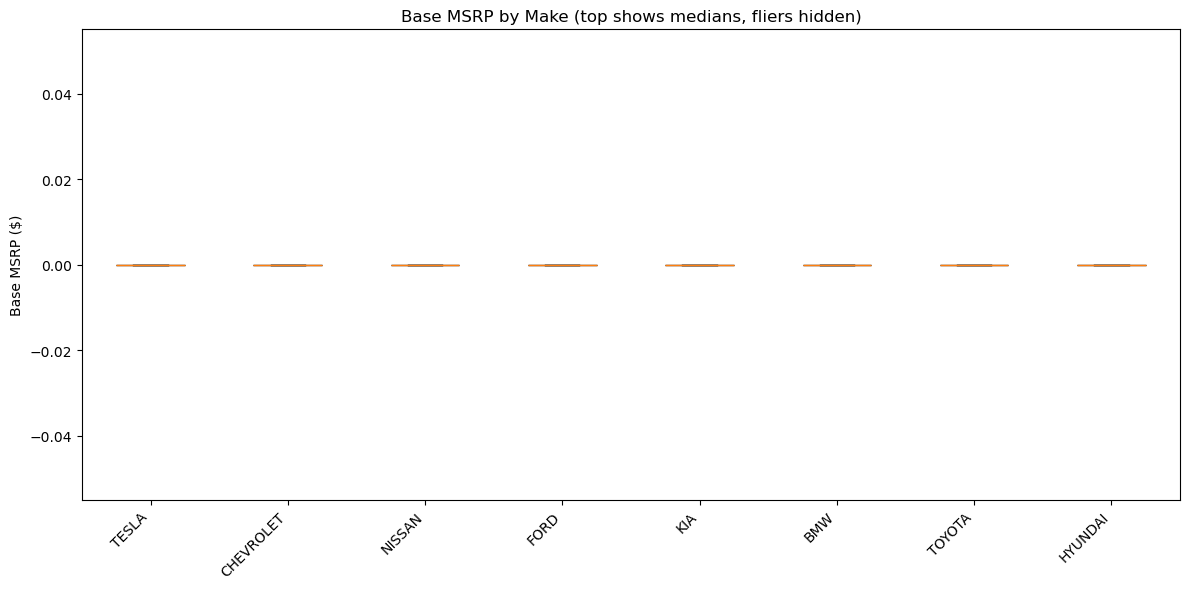

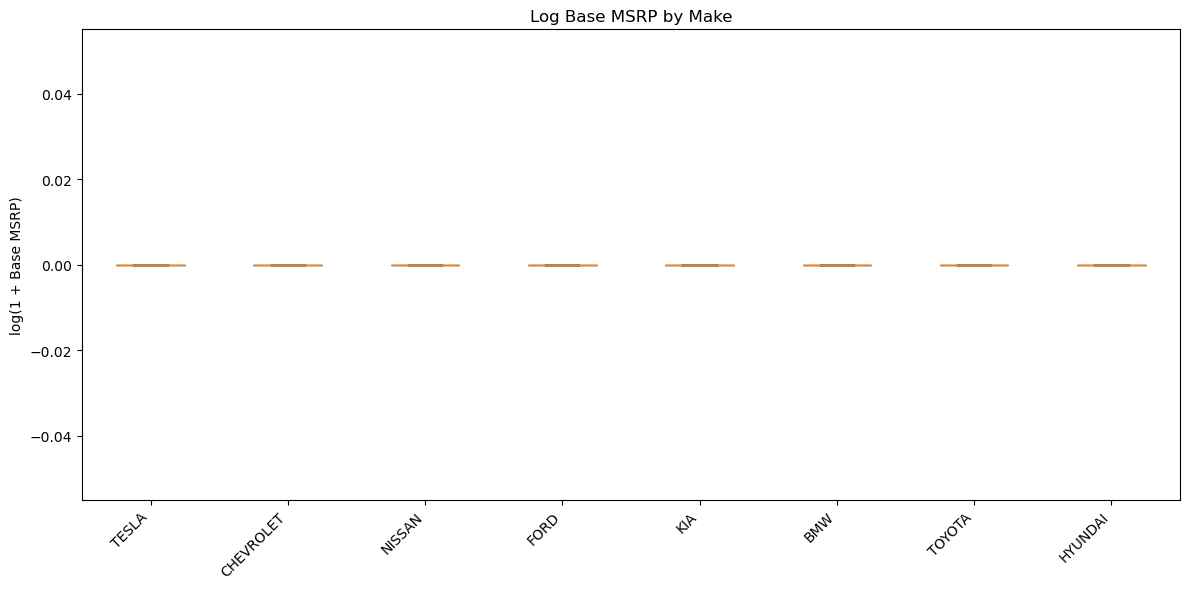

In [250]:
# Cell 4: Boxplot MSRP by make (hide outliers to see distribution)
plt.figure(figsize=(12,6))
data = [df_top[df_top['make']==m]['base_msrp'].dropna() for m in top_makes]
plt.boxplot(data, labels=top_makes, showfliers=False, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Base MSRP ($)')
plt.title('Base MSRP by Make (top shows medians, fliers hidden)')
plt.tight_layout()
plt.show()

# Optional: same on log-scale for heavy-tailed distribution
plt.figure(figsize=(12,6))
plt.boxplot([np.log1p(s) for s in data], labels=top_makes, showfliers=False, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel('log(1 + Base MSRP)')
plt.title('Log Base MSRP by Make')
plt.tight_layout()
plt.show()


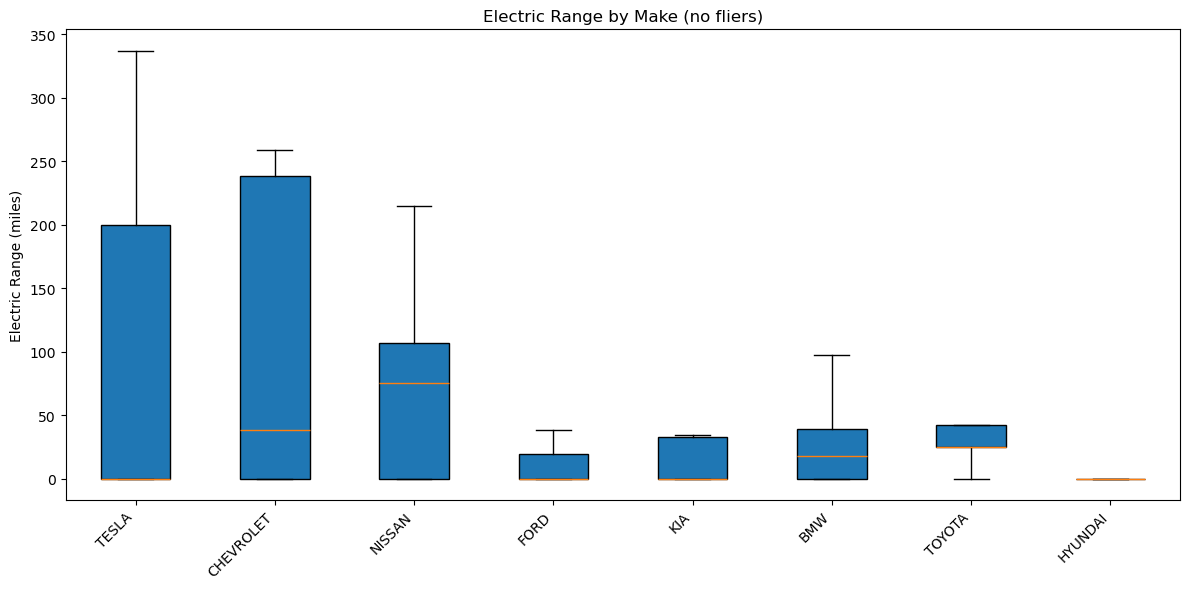

In [251]:
# Cell 5: Boxplot: electric range by make
if 'electric_range' in df.columns:
    plt.figure(figsize=(12,6))
    data_r = [df_top[df_top['make']==m]['electric_range'].dropna() for m in top_makes]
    plt.boxplot(data_r, labels=top_makes, showfliers=False, patch_artist=True)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Electric Range (miles)')
    plt.title('Electric Range by Make (no fliers)')
    plt.tight_layout()
    plt.show()
else:
    print("electric_range not present")


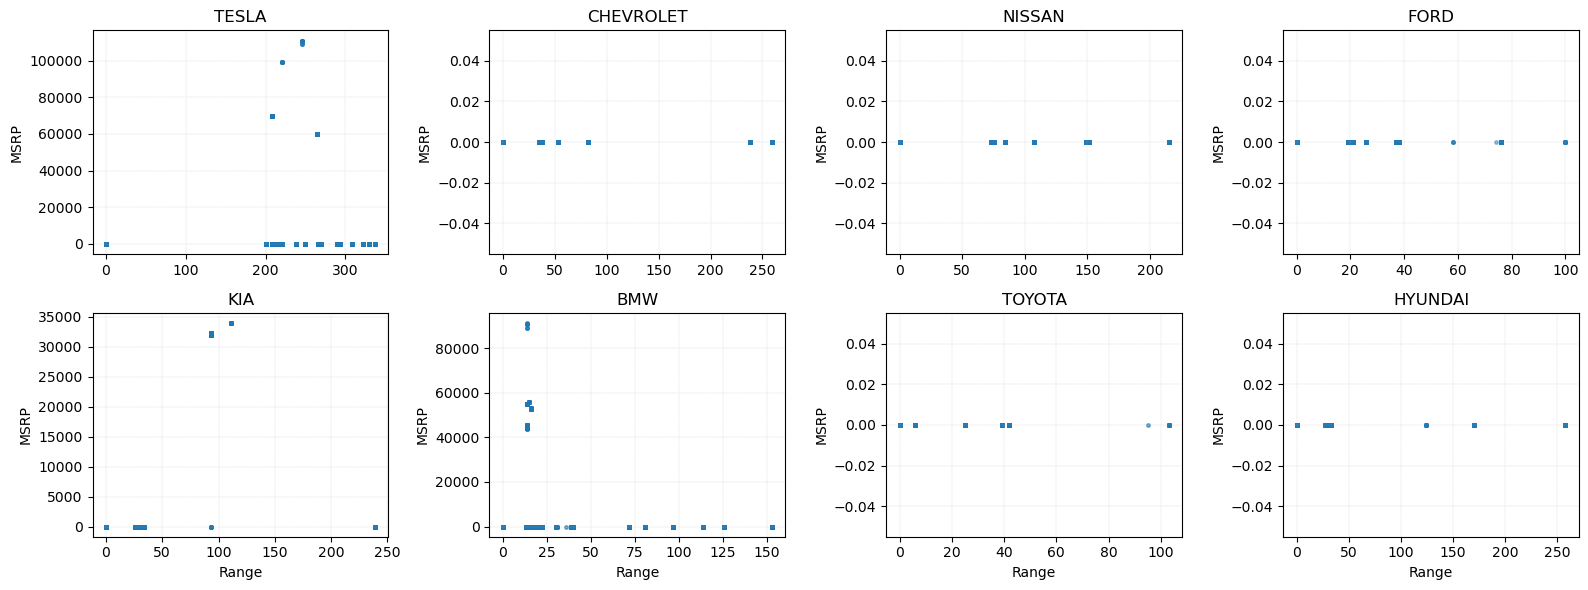

In [252]:
# Cell 6: Scatter subplots - electric_range vs base_msrp per make
cols = top_makes
n = len(cols)
ncols = 4
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()
for i, make in enumerate(cols):
    ax = axes[i]
    sub = df[df['make']==make]
    x = sub['electric_range'] if 'electric_range' in sub else None
    y = sub['base_msrp'] if 'base_msrp' in sub else None
    ax.scatter(x, y, s=6, alpha=0.25)
    ax.set_title(make)
    ax.set_xlabel('Range' if i//ncols==nrows-1 else '')
    ax.set_ylabel('MSRP')
    ax.grid(True, linestyle=':', linewidth=0.3)
# hide unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


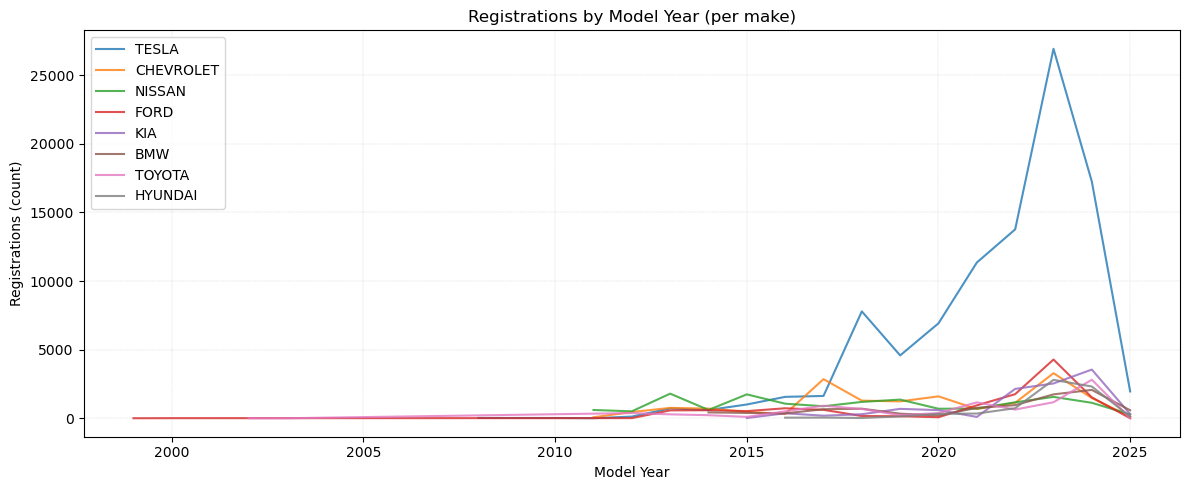

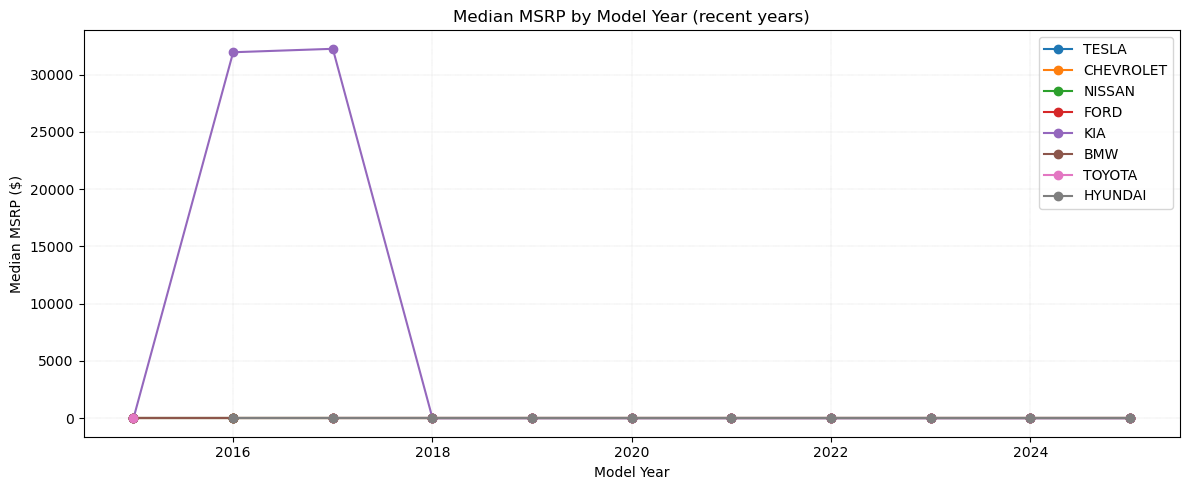

In [253]:
# Cell 7: time trend: registrations per model year and median MSRP
if 'model_year' in df.columns:
    plt.figure(figsize=(12,5))
    for make in top_makes:
        series = df[df['make']==make]['model_year'].value_counts().sort_index()
        plt.plot(series.index, series.values, label=make, alpha=0.8)
    plt.legend()
    plt.xlabel('Model Year')
    plt.ylabel('Registrations (count)')
    plt.title('Registrations by Model Year (per make)')
    plt.grid(True, linestyle=':', linewidth=0.3)
    plt.tight_layout()
    plt.show()

    # median MSRP trend per make (last 10 years)
    years = sorted(df['model_year'].dropna().unique())
    recent = [y for y in years if y >= (max(years)-10)]
    plt.figure(figsize=(12,5))
    for make in top_makes:
        medians = df[df['make']==make].groupby('model_year')['base_msrp'].median().reindex(recent)
        plt.plot(recent, medians.values, marker='o', label=make)
    plt.legend()
    plt.xlabel('Model Year')
    plt.ylabel('Median MSRP ($)')
    plt.title('Median MSRP by Model Year (recent years)')
    plt.grid(True, linestyle=':', linewidth=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("model_year not present")


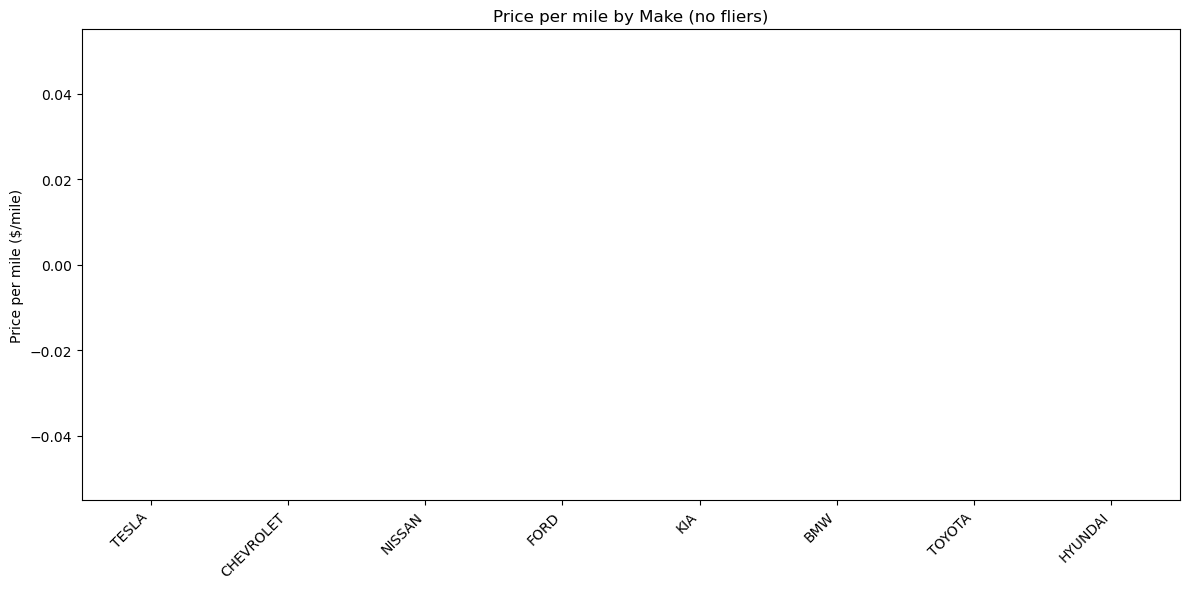

In [254]:
# Cell 8: Price-per-mile boxplots / violin (use boxplot)
if 'price_per_mile' in df.columns:
    plt.figure(figsize=(12,6))
    data_ppm = [df_top[df_top['make']==m]['price_per_mile'].dropna() for m in top_makes]
    plt.boxplot(data_ppm, labels=top_makes, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Price per mile ($/mile)')
    plt.title('Price per mile by Make (no fliers)')
    plt.tight_layout()
    plt.show()
else:
    print("price_per_mile not present")


In [255]:
# Cell 9: CAFV and BEV/PHEV split
for make in top_makes:
    sub = df[df['make']==make]
    bev_count = sub['electric_vehicle_type'].value_counts().get('BEV', 0)
    phev_count = sub['electric_vehicle_type'].value_counts().get('PHEV', 0)
    total = len(sub)
    cafv_counts = sub['clean_alternative_fuel_vehicle_cafv_eligibility'].value_counts().to_dict()
    print(f"{make}: total={total}, BEV={bev_count}, PHEV={phev_count}, CAFV sample={cafv_counts}")


TESLA: total=96180, BEV=0, PHEV=0, CAFV sample={'Eligibility unknown as battery range has not been researched': 71221, 'Clean Alternative Fuel Vehicle Eligible': 24959}
CHEVROLET: total=16405, BEV=0, PHEV=0, CAFV sample={'Clean Alternative Fuel Vehicle Eligible': 9720, 'Eligibility unknown as battery range has not been researched': 6685}
NISSAN: total=15259, BEV=0, PHEV=0, CAFV sample={'Clean Alternative Fuel Vehicle Eligible': 10369, 'Eligibility unknown as battery range has not been researched': 4890}
FORD: total=11930, BEV=0, PHEV=0, CAFV sample={'Eligibility unknown as battery range has not been researched': 7994, 'Not eligible due to low battery range': 3187, 'Clean Alternative Fuel Vehicle Eligible': 749}
KIA: total=10760, BEV=0, PHEV=0, CAFV sample={'Eligibility unknown as battery range has not been researched': 6192, 'Clean Alternative Fuel Vehicle Eligible': 3736, 'Not eligible due to low battery range': 832}
BMW: total=9171, BEV=0, PHEV=0, CAFV sample={'Clean Alternative Fuel

In [256]:
# Cell 10: Save per-make CSVs and a combined per-make pivot summary
OUTDIR = "/mnt/data/per_make_details"
os.makedirs(OUTDIR, exist_ok=True)
for make in top_makes:
    sub = df[df['make']==make]
    outp = os.path.join(OUTDIR, f"{make.replace(' ','_')}_sample.csv")
    sub.to_csv(outp, index=False)
print("Saved per-make CSVs to", OUTDIR)

# Combined pivot: make x (median base_msrp, median range, count)
pivot = df.groupby('make').agg(
    count=('vin_1_10','count'),
    median_msrp=('base_msrp','median'),
    median_range=('electric_range','median'),
    avg_age=('vehicle_age','mean')
).sort_values('count', ascending=False)
pivot.to_csv('/mnt/data/per_make_pivot.csv')
display(pivot.head(TOP_N))
print("Saved pivot to /mnt/data/per_make_pivot.csv")


Saved per-make CSVs to /mnt/data/per_make_details


,count,median_msrp,median_range,avg_age
make,,,,
TESLA,96180,0.0,0.0,3.420025
CHEVROLET,16405,0.0,38.0,5.633465
NISSAN,15259,0.0,75.0,7.055705
FORD,11930,0.0,0.0,4.347611
KIA,10760,0.0,0.0,2.742751
BMW,9171,0.0,18.0,3.970559
TOYOTA,8956,0.0,25.0,4.335976
HYUNDAI,6878,0.0,0.0,2.152224


Saved pivot to /mnt/data/per_make_pivot.csv


In [257]:
# Cell 11: quick automated insights (text)
insights = []
# Most common make
most_common = df['make'].value_counts().idxmax()
insights.append(f"Most common make overall: {most_common}")

# Highest median range among top makes
median_range = df[df['make'].isin(top_makes)].groupby('make')['electric_range'].median().sort_values(ascending=False)
insights.append("Top makes by median range:\n" + median_range.head(5).to_string())

# Highest median price among top makes
median_price = df[df['make'].isin(top_makes)].groupby('make')['base_msrp'].median().sort_values(ascending=False)
insights.append("Top makes by median MSRP:\n" + median_price.head(5).to_string())

for s in insights:
    print(" -", s)


 - Most common make overall: TESLA
 - Top makes by median range:
make
NISSAN       75.0
CHEVROLET    38.0
TOYOTA       25.0
BMW          18.0
FORD          0.0
 - Top makes by median MSRP:
make
BMW          0.0
CHEVROLET    0.0
FORD         0.0
HYUNDAI      0.0
KIA          0.0


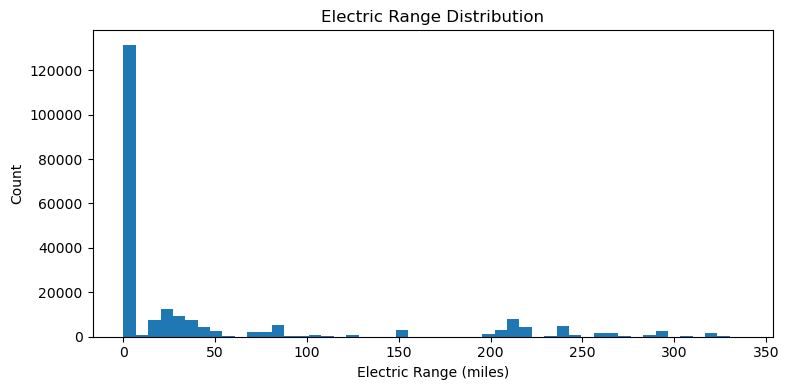

In [258]:
# Cell 2: Histogram of Electric Range
if 'electric_range' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['electric_range'].dropna(), bins=50)
    plt.title("Electric Range Distribution")
    plt.xlabel("Electric Range (miles)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'electric_range' not found.")


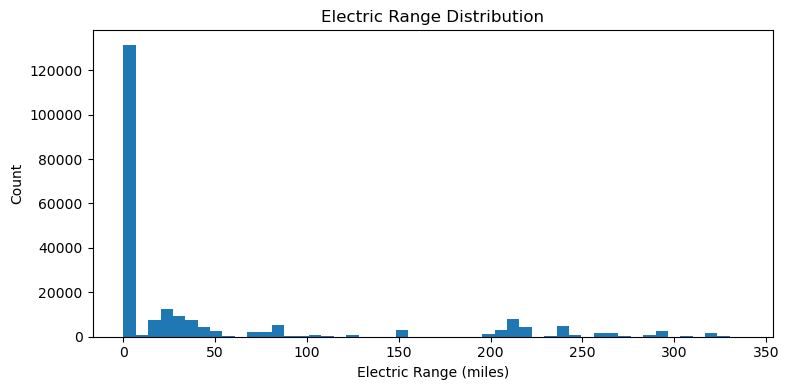

In [259]:
# Cell 2: Histogram of Electric Range
if 'electric_range' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['electric_range'].dropna(), bins=50)
    plt.title("Electric Range Distribution")
    plt.xlabel("Electric Range (miles)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'electric_range' not found.")


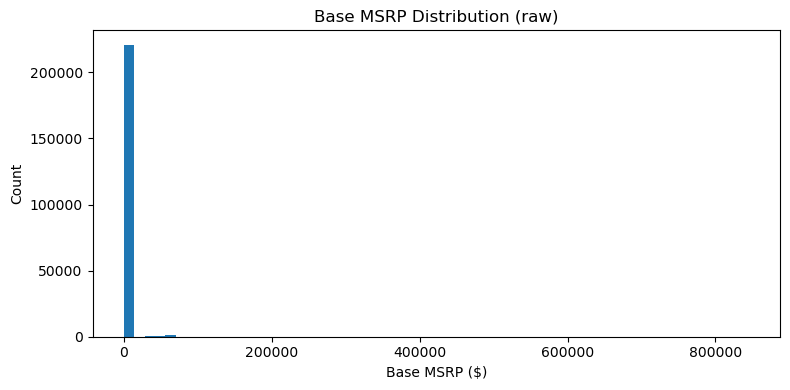

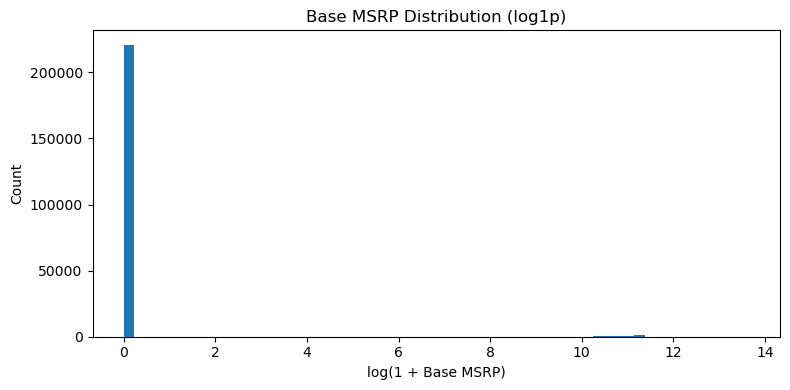

In [260]:
# Cell 3: Histogram of Base MSRP (raw and log-scale inset)
if 'base_msrp' in df.columns:
    vals = df['base_msrp'].dropna()
    plt.figure(figsize=(8,4))
    plt.hist(vals, bins=60)
    plt.title("Base MSRP Distribution (raw)")
    plt.xlabel("Base MSRP ($)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Log-scale histogram to show tail
    plt.figure(figsize=(8,4))
    plt.hist(np.log1p(vals), bins=60)
    plt.title("Base MSRP Distribution (log1p)")
    plt.xlabel("log(1 + Base MSRP)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'base_msrp' not found.")


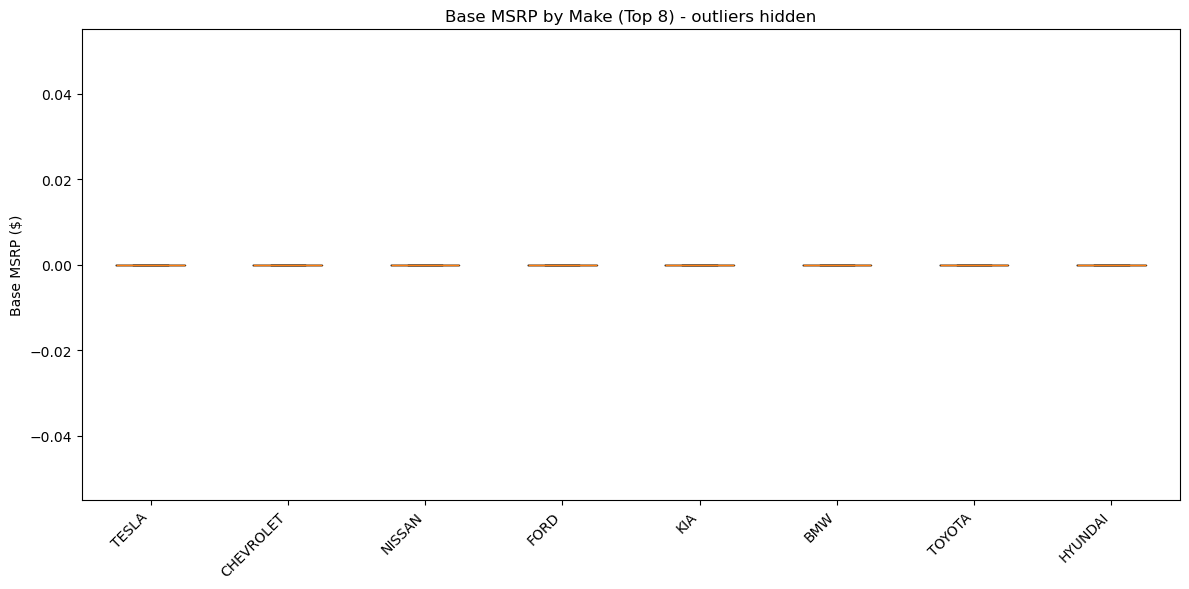

In [261]:
# Cell 4: Boxplot of Base MSRP for top N makes
TOP_N = 8
if 'make' in df.columns and 'base_msrp' in df.columns:
    top_makes = df['make'].value_counts().head(TOP_N).index.tolist()
    df_top = df[df['make'].isin(top_makes)]
    data = [df_top[df_top['make']==m]['base_msrp'].dropna() for m in top_makes]

    plt.figure(figsize=(12,6))
    plt.boxplot(data, labels=top_makes, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Base MSRP ($)")
    plt.title(f"Base MSRP by Make (Top {TOP_N}) - outliers hidden")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('make','base_msrp') not found.")


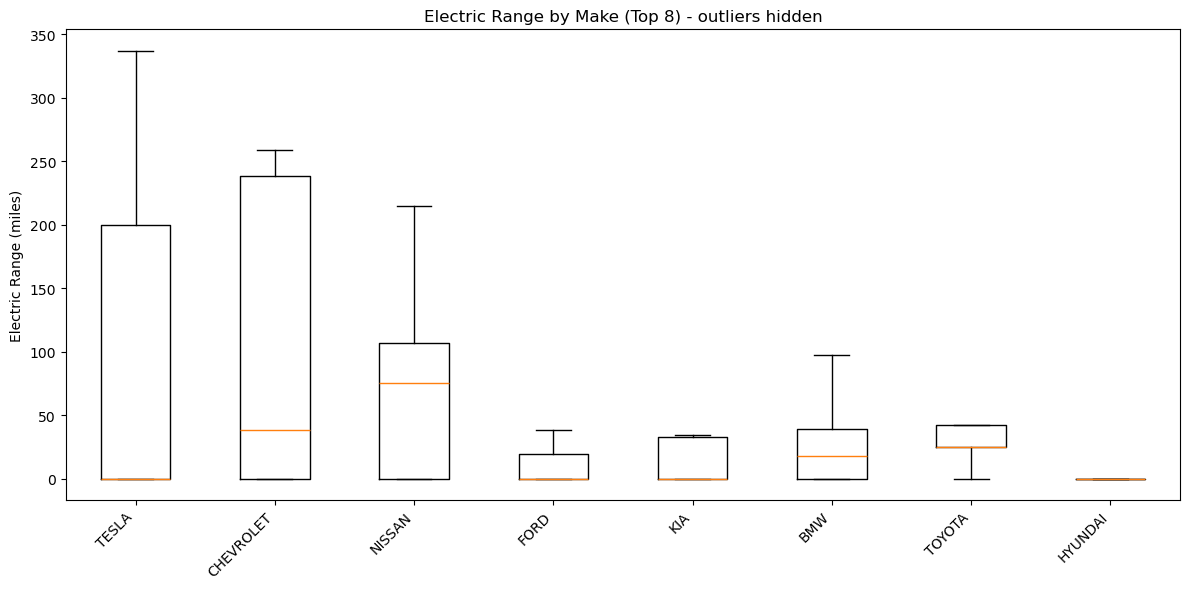

In [262]:
# Cell 5: Boxplot of Electric Range for top N makes
TOP_N = 8
if 'make' in df.columns and 'electric_range' in df.columns:
    top_makes = df['make'].value_counts().head(TOP_N).index.tolist()
    df_top = df[df['make'].isin(top_makes)]
    data = [df_top[df_top['make']==m]['electric_range'].dropna() for m in top_makes]

    plt.figure(figsize=(12,6))
    plt.boxplot(data, labels=top_makes, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Electric Range (miles)")
    plt.title(f"Electric Range by Make (Top {TOP_N}) - outliers hidden")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('make','electric_range') not found.")


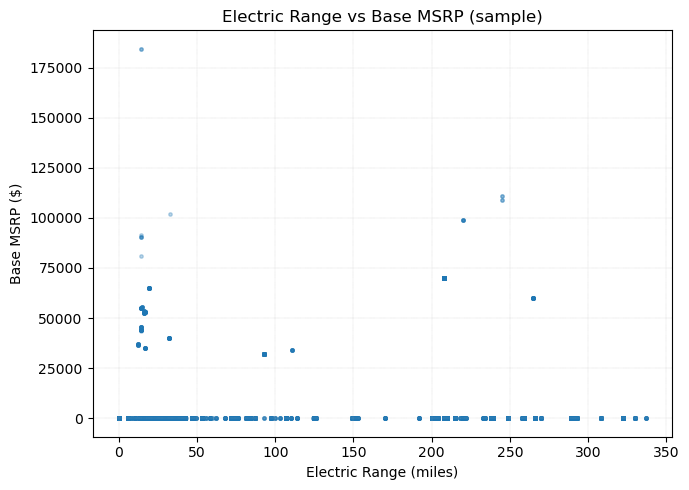

In [263]:
# Cell 6: Scatter plot Range vs MSRP (sampling for speed)
if 'electric_range' in df.columns and 'base_msrp' in df.columns:
    sample = df[['electric_range','base_msrp']].dropna().sample(n=min(30000, len(df)), random_state=42)
    plt.figure(figsize=(7,5))
    plt.scatter(sample['electric_range'], sample['base_msrp'], s=6, alpha=0.3)
    plt.xlabel("Electric Range (miles)")
    plt.ylabel("Base MSRP ($)")
    plt.title("Electric Range vs Base MSRP (sample)")
    plt.grid(True, linestyle=':', linewidth=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for scatter.")


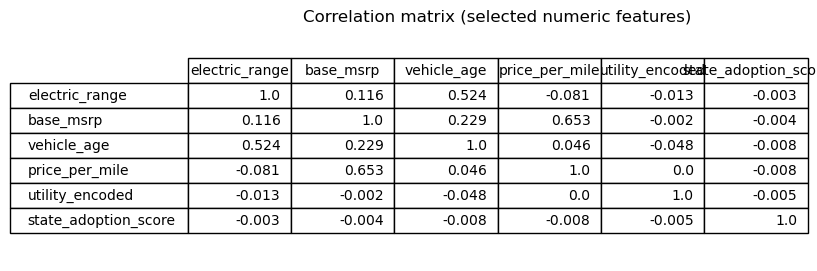

In [264]:
# Cell 7: Correlations for key numeric features (display table)
numeric_candidates = ['electric_range','base_msrp','vehicle_age','price_per_mile','utility_encoded','state_adoption_score']
present = [c for c in numeric_candidates if c in df.columns]
if len(present) >= 2:
    corr = df[present].corr().round(3)
    # Show as table image-like with matplotlib table
    fig, ax = plt.subplots(figsize=(8, max(2, 0.5*len(present))))
    ax.axis('off')
    table = ax.table(cellText=corr.values, rowLabels=corr.index, colLabels=corr.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title("Correlation matrix (selected numeric features)")
    plt.show()
else:
    print("Not enough numeric columns found for correlation table. Present:", present)


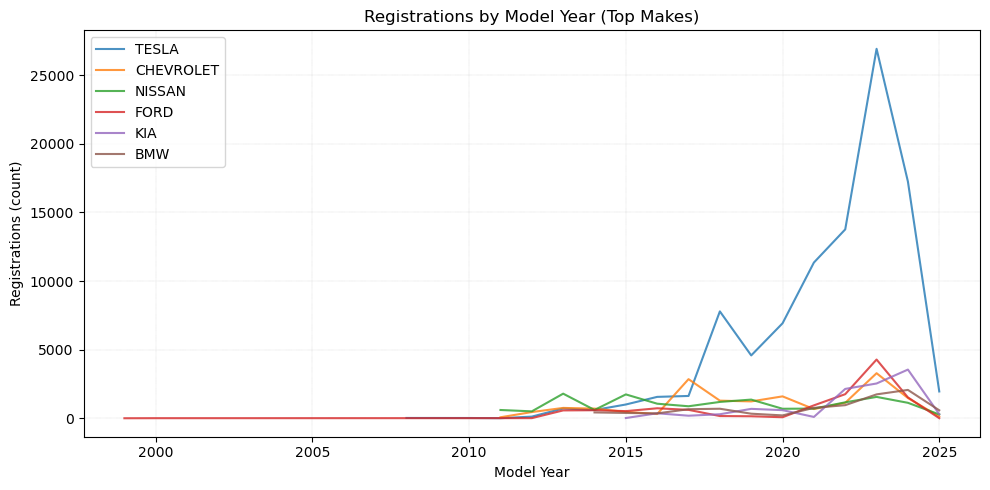

In [265]:
# Cell 8: Registrations by model_year for top makes (stacked line)
if 'model_year' in df.columns and 'make' in df.columns:
    top_makes = df['make'].value_counts().head(6).index.tolist()
    plt.figure(figsize=(10,5))
    for make in top_makes:
        series = df[df['make']==make]['model_year'].value_counts().sort_index()
        plt.plot(series.index, series.values, label=make, alpha=0.8)
    plt.legend()
    plt.xlabel("Model Year")
    plt.ylabel("Registrations (count)")
    plt.title("Registrations by Model Year (Top Makes)")
    plt.grid(True, linestyle=':', linewidth=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'model_year' or 'make' missing.")


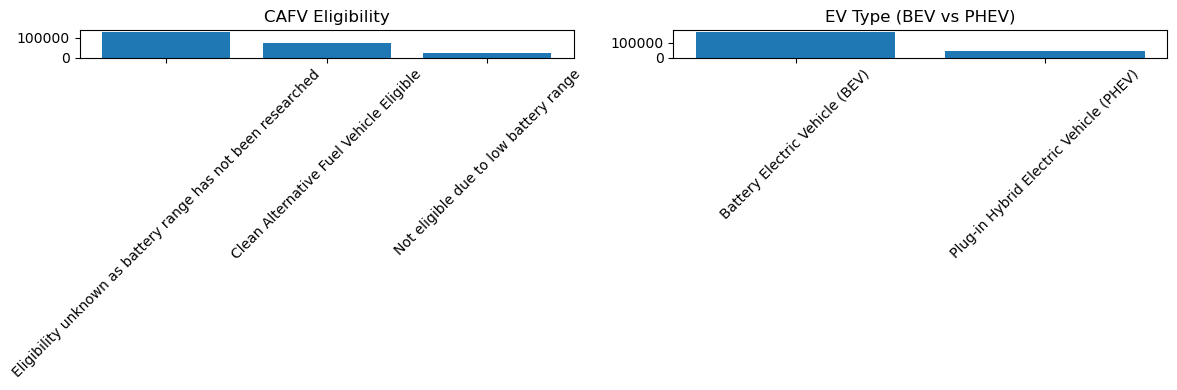

In [266]:
# Cell 9: CAFV eligibility and BEV/PHEV split
fig, axes = plt.subplots(1,2, figsize=(12,4))

if 'clean_alternative_fuel_vehicle_cafv_eligibility' in df.columns:
    vc = df['clean_alternative_fuel_vehicle_cafv_eligibility'].value_counts()
    axes[0].bar(vc.index.astype(str), vc.values)
    axes[0].set_title("CAFV Eligibility")
    axes[0].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5,0.5,"CAFV column missing", ha='center')

if 'electric_vehicle_type' in df.columns:
    vc2 = df['electric_vehicle_type'].value_counts()
    axes[1].bar(vc2.index.astype(str), vc2.values)
    axes[1].set_title("EV Type (BEV vs PHEV)")
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5,0.5,"EV type column missing", ha='center')

plt.tight_layout()
plt.show()


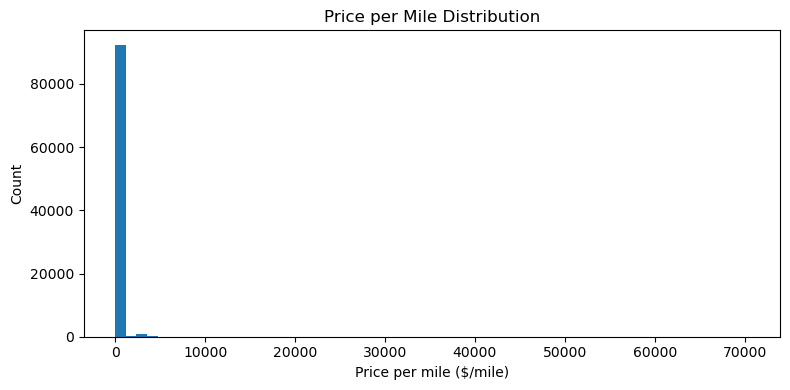

Price per mile percentiles:
 0.01: nan
 0.05: nan
 0.25: nan
 0.50: nan
 0.75: nan
 0.95: nan
 0.99: nan


In [267]:
# Cell 10: Price per mile distribution and percentiles
if 'price_per_mile' in df.columns:
    vals = df['price_per_mile'].dropna()
    plt.figure(figsize=(8,4))
    plt.hist(vals, bins=60)
    plt.title("Price per Mile Distribution")
    plt.xlabel("Price per mile ($/mile)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    pct = vals.quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_dict()
    print("Price per mile percentiles:")
    for k,v in pct.items():
        print(f" {k:.2f}: {v:.2f}")
else:
    print("price_per_mile not present")


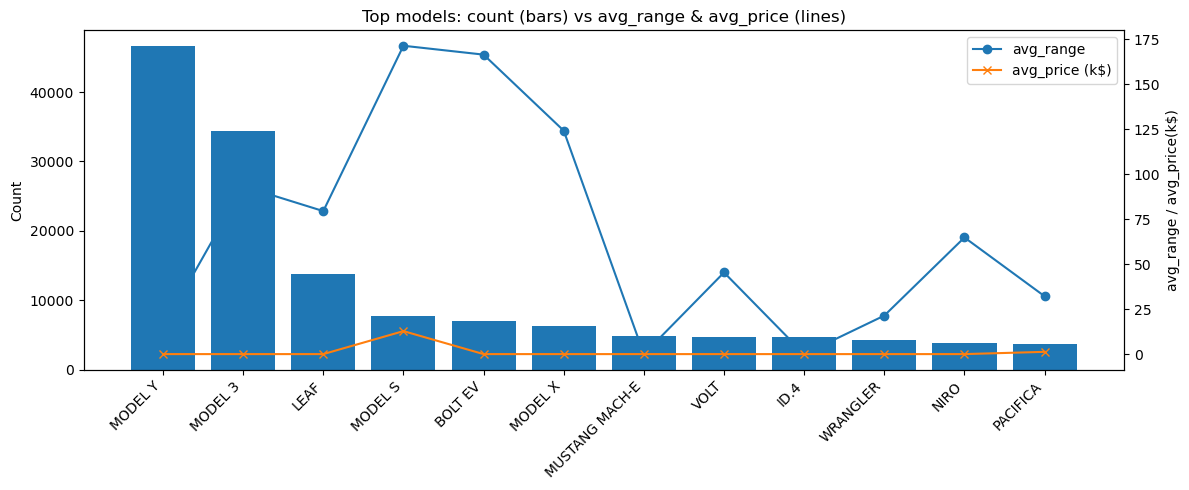

In [268]:
# Cell 11: Top models by count with average range & price
if 'model' in df.columns:
    top_models = df['model'].value_counts().head(12).index.tolist()
    agg = df[df['model'].isin(top_models)].groupby('model').agg(
        count=('vin_1_10','count'),
        avg_range=('electric_range','mean'),
        avg_price=('base_msrp','mean')
    ).loc[top_models]
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax1.bar(agg.index, agg['count'])
    ax1.set_ylabel('Count', color='k')
    ax2 = ax1.twinx()
    ax2.plot(agg.index, agg['avg_range'], marker='o', label='avg_range')
    ax2.plot(agg.index, agg['avg_price']/1000, marker='x', label='avg_price (k$)')
    ax2.set_ylabel('avg_range / avg_price(k$)')
    ax1.set_xticklabels(agg.index, rotation=45, ha='right')
    ax2.legend(loc='upper right')
    plt.title("Top models: count (bars) vs avg_range & avg_price (lines)")
    plt.tight_layout()
    plt.show()
else:
    print("model column missing.")


In [269]:
# Cell 12: Geospatial scattermap using folium (saves HTML) - optional
# Requires folium installed. Creates a simple HTML map with sample points
try:
    import folium
    if 'latitude' in df.columns and 'longitude' in df.columns:
        sample = df.dropna(subset=['latitude','longitude']).sample(n=min(5000, len(df)), random_state=1)
        # center map on median coords
        center_lat = sample['latitude'].median()
        center_lon = sample['longitude'].median()
        m = folium.Map(location=[center_lat, center_lon], zoom_start=8)
        for _, r in sample.iterrows():
            folium.CircleMarker(location=[r['latitude'], r['longitude']],
                                radius=2,
                                popup=str(r.get('make','')) + ' ' + str(r.get('model','')),
                                fill=True).add_to(m)
        map_path = os.path.join(OUT_DIR, "ev_points_map.html")
        m.save(map_path)
        print("Saved folium map to", map_path)
    else:
        print("latitude/longitude columns not found; skipping folium map.")
except Exception as e:
    print("Folium not installed or error creating map:", e)


Folium not installed or error creating map: No module named 'folium'


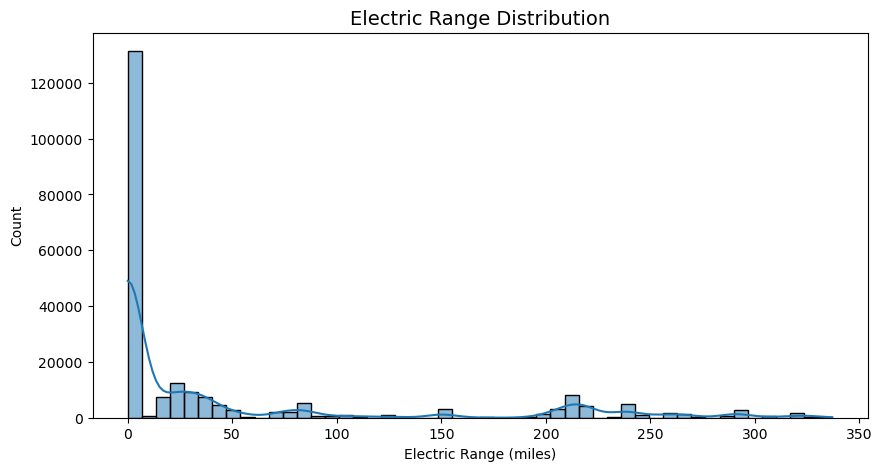

In [270]:
plt.figure(figsize=(10,5))
sns.histplot(df['electric_range'], bins=50, kde=True)
plt.title("Electric Range Distribution", fontsize=14)
plt.xlabel("Electric Range (miles)")
plt.ylabel("Count")
plt.show()


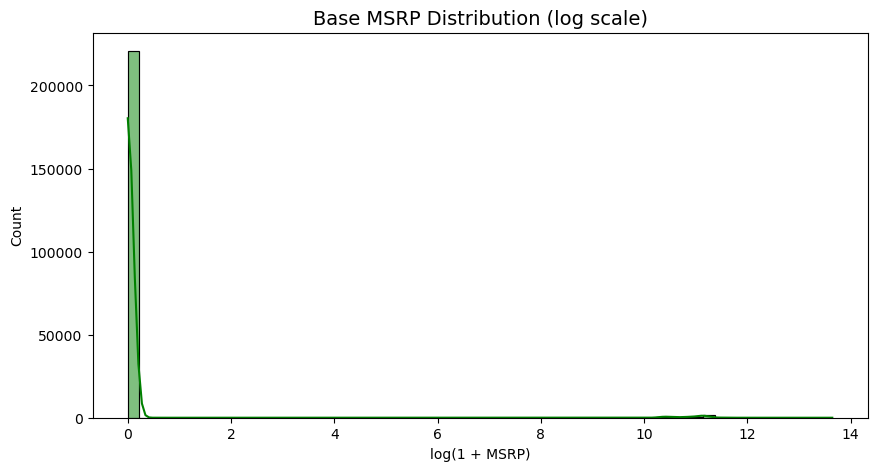

In [271]:
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df['base_msrp']), bins=60, kde=True, color='green')
plt.title("Base MSRP Distribution (log scale)", fontsize=14)
plt.xlabel("log(1 + MSRP)")
plt.ylabel("Count")
plt.show()


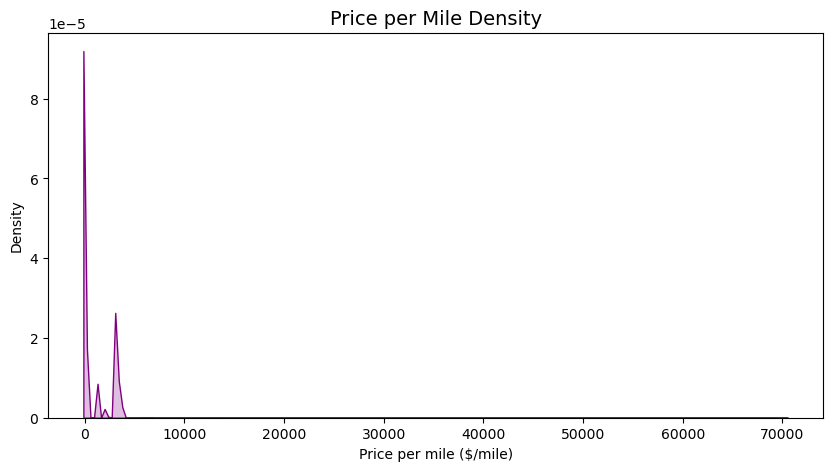

In [272]:
plt.figure(figsize=(10,5))
sns.kdeplot(df['price_per_mile'], fill=True, color='purple')
plt.title("Price per Mile Density", fontsize=14)
plt.xlabel("Price per mile ($/mile)")
plt.show()


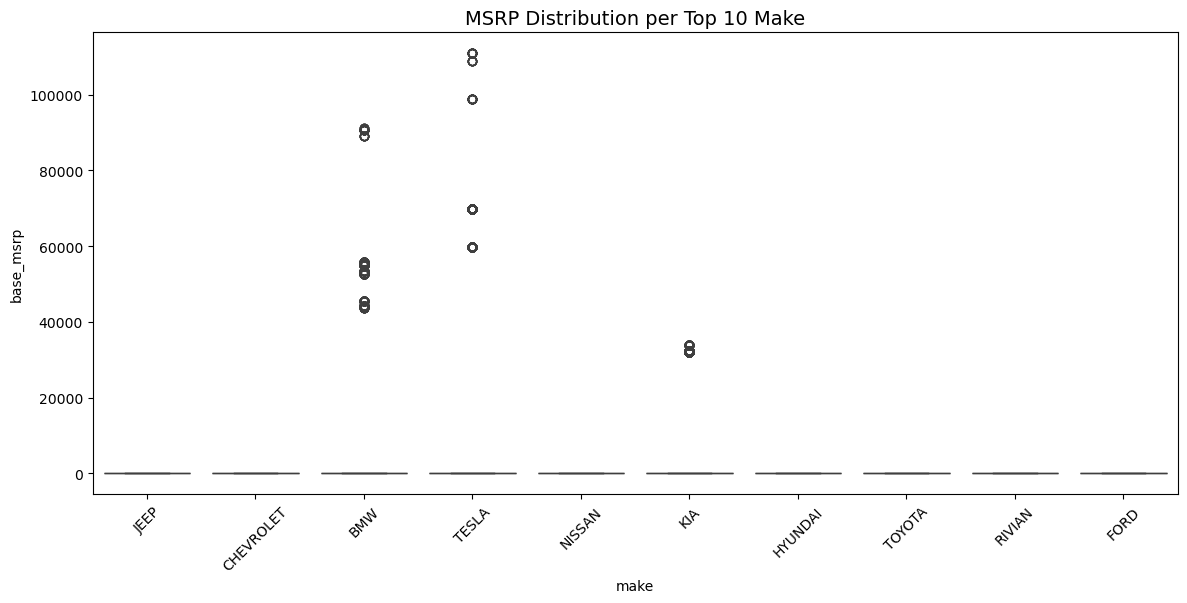

In [273]:
top_makes = df['make'].value_counts().head(10).index
df_top = df[df['make'].isin(top_makes)]

plt.figure(figsize=(14,6))
sns.boxplot(data=df_top, x='make', y='base_msrp')
plt.title("MSRP Distribution per Top 10 Make", fontsize=14)
plt.xticks(rotation=45)
plt.show()


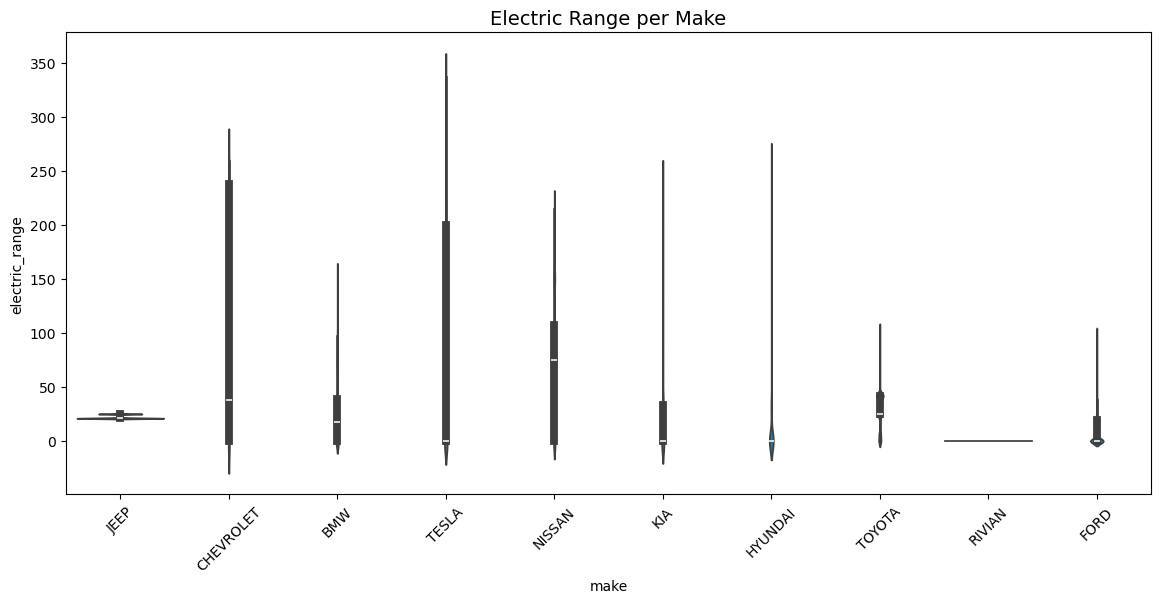

In [274]:
plt.figure(figsize=(14,6))
sns.violinplot(data=df_top, x='make', y='electric_range')
plt.title("Electric Range per Make", fontsize=14)
plt.xticks(rotation=45)
plt.show()


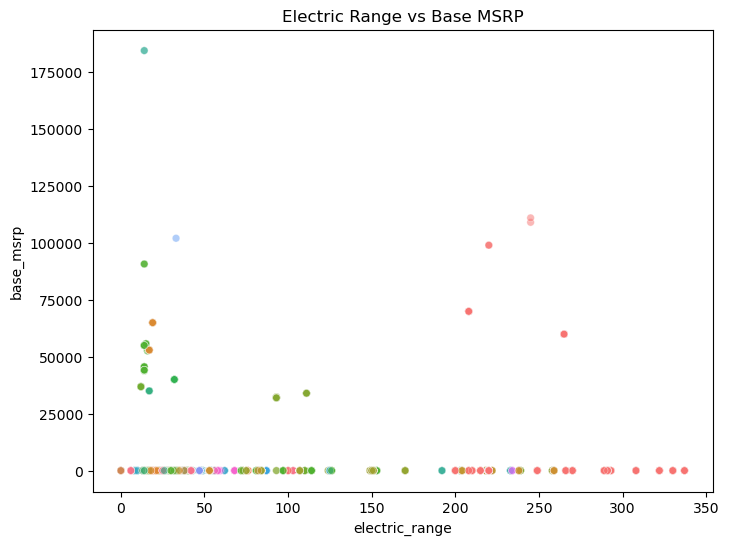

In [275]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df.sample(20000, random_state=42), 
                x='electric_range', y='base_msrp', hue='make', s=30, alpha=0.5, legend=False)
plt.title("Electric Range vs Base MSRP")
plt.show()


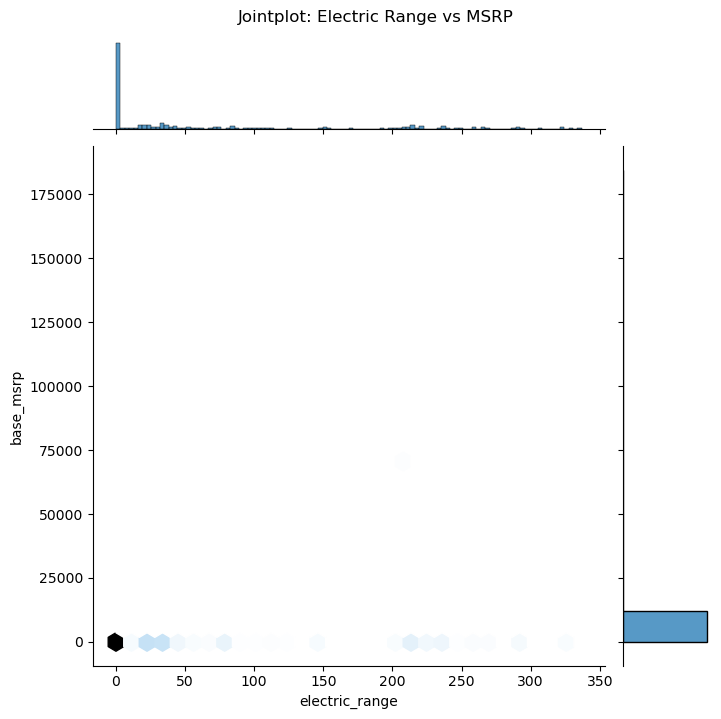

In [276]:
sns.jointplot(
    data=df.sample(15000, random_state=42),
    x='electric_range',
    y='base_msrp',
    kind='hex',
    height=7,
    gridsize=30
)
plt.suptitle("Jointplot: Electric Range vs MSRP", y=1.02)
plt.show()


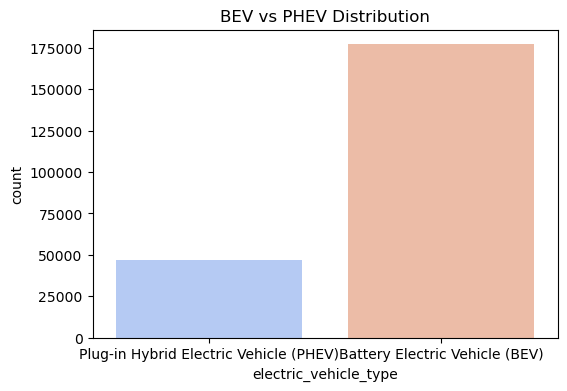

In [277]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='electric_vehicle_type', palette='coolwarm')
plt.title("BEV vs PHEV Distribution")
plt.show()


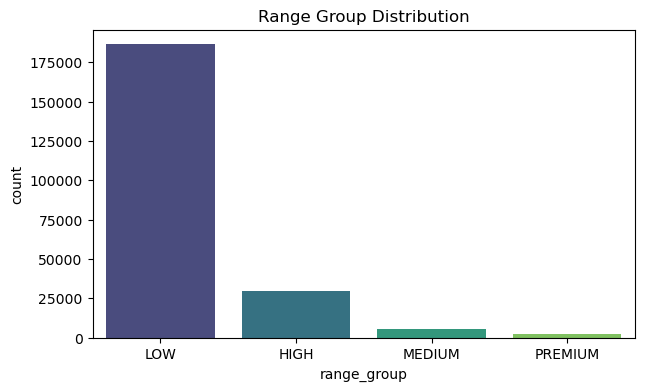

In [278]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='range_group', palette='viridis')
plt.title("Range Group Distribution")
plt.show()


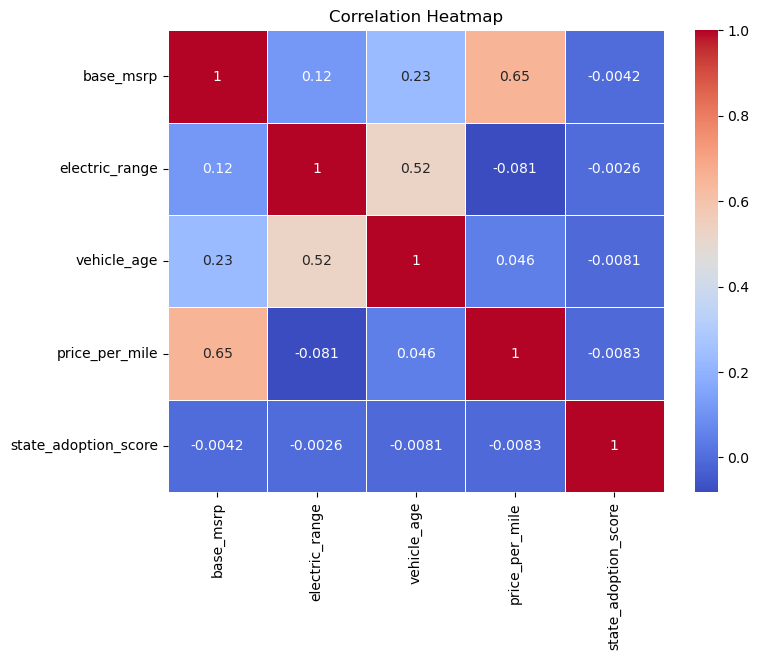

In [279]:
num_cols = ['base_msrp','electric_range','vehicle_age','price_per_mile','state_adoption_score']

corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


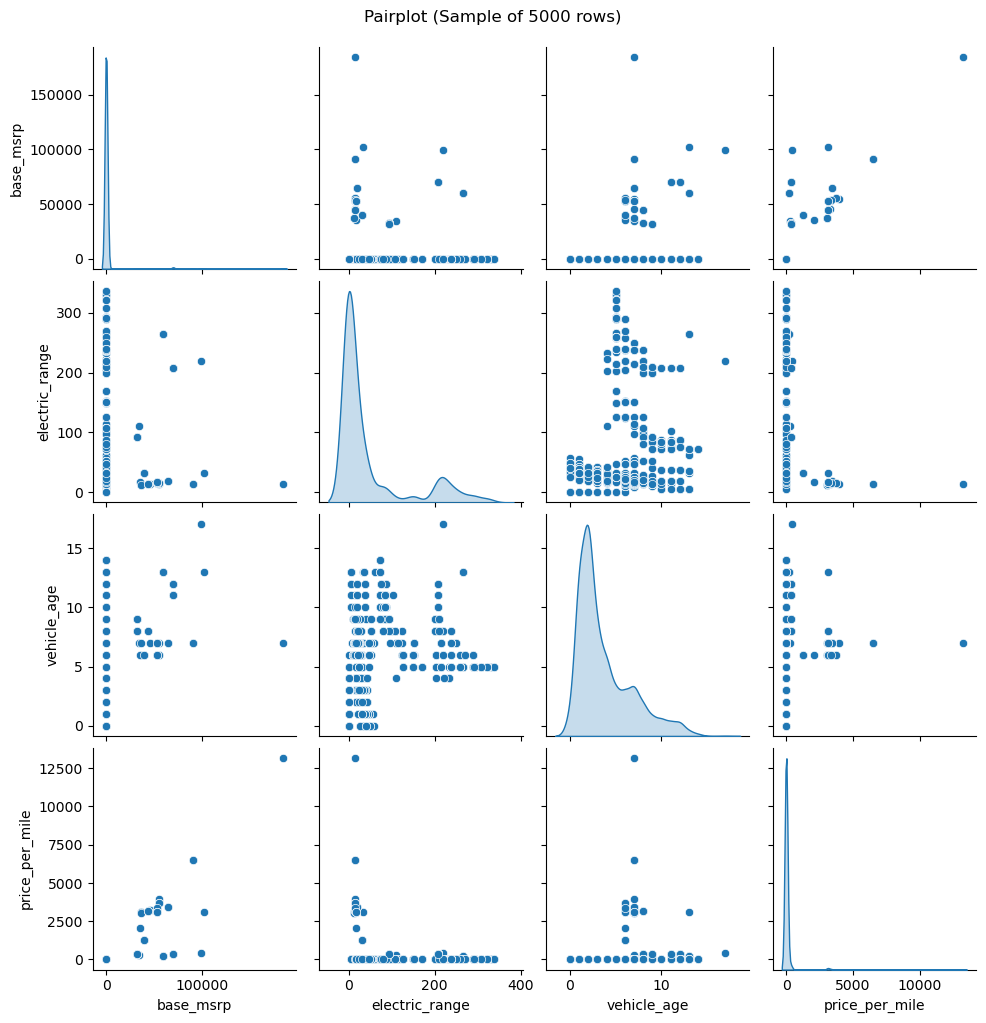

In [280]:
sample = df[['base_msrp','electric_range','vehicle_age','price_per_mile']].sample(5000, random_state=42)

sns.pairplot(sample, diag_kind="kde")
plt.suptitle("Pairplot (Sample of 5000 rows)", y=1.02)
plt.show()


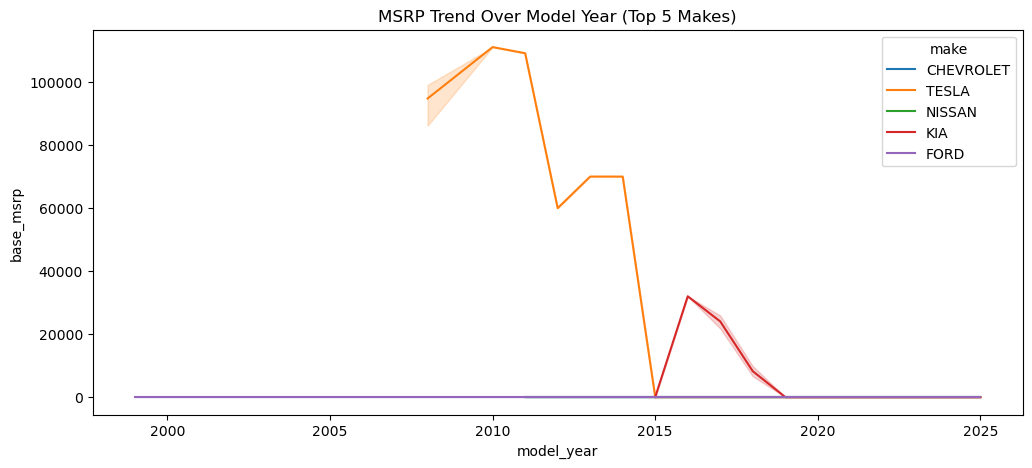

In [281]:
top_makes = df['make'].value_counts().head(5).index
df_trend = df[df['make'].isin(top_makes)]

plt.figure(figsize=(12,5))
sns.lineplot(data=df_trend, x='model_year', y='base_msrp', hue='make')
plt.title("MSRP Trend Over Model Year (Top 5 Makes)")
plt.show()


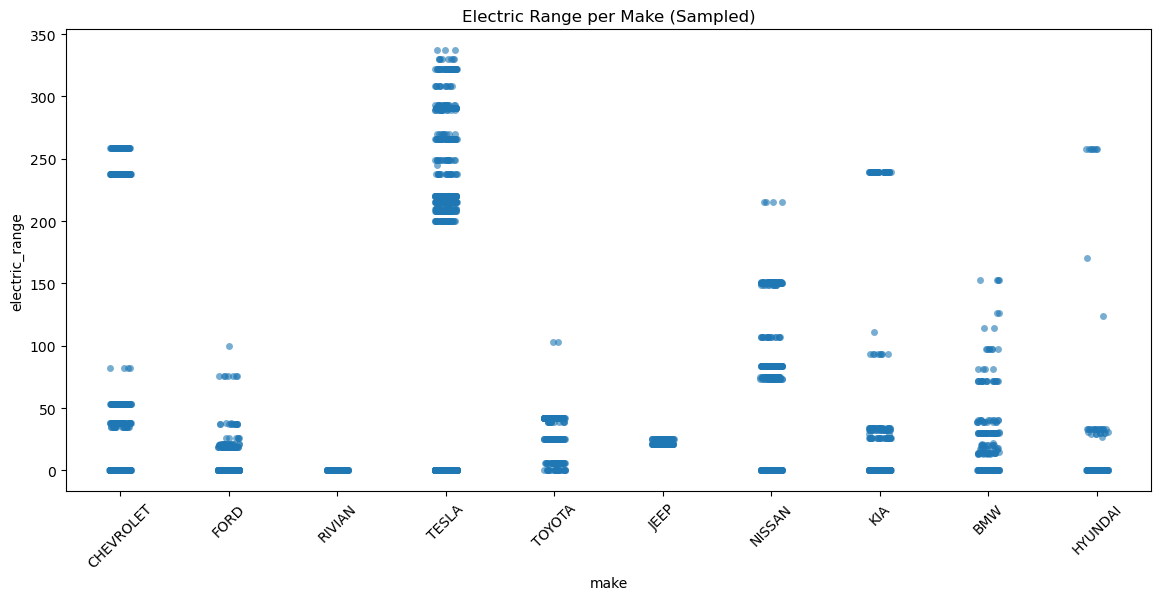

In [282]:
plt.figure(figsize=(14,6))
sns.stripplot(data=df_top.sample(5000), x='make', y='electric_range', dodge=True, alpha=0.6)
plt.xticks(rotation=45)
plt.title("Electric Range per Make (Sampled)")
plt.show()


In [283]:
# Cell 1: Safe environment + imports
import os
# limit BLAS threads early (helps on limited VMs)
os.environ.setdefault("OPENBLAS_NUM_THREADS","1")
os.environ.setdefault("OMP_NUM_THREADS","1")
os.environ.setdefault("MKL_NUM_THREADS","1")

import json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import joblib

print("Imports done.")


Imports done.


In [284]:
# Cell 2: Load dataset (memory-safe)
DATA_PATH = r"C:\Users\HP\OneDrive\Desktop\Internship\AI & Green Skills\EV\ev_feature_engineered.csv"   # change if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

# Option A: load full file (only if you have enough RAM)
# df = pd.read_csv(DATA_PATH, low_memory=False)

# Option B (recommended): load a random sample in chunks to limit memory usage
SAMPLE_ROWS = None   # set to integer (e.g., 50000) to sample ~50k rows, or None to use full file
if SAMPLE_ROWS is None:
    df = pd.read_csv(DATA_PATH, low_memory=False)
    print("Loaded full dataset:", df.shape)
else:
    # read in chunks and sample ~SAMPLE_ROWS in total
    chunksize = 50000
    chosen = []
    total = 0
    import random
    for chunk in pd.read_csv(DATA_PATH, chunksize=chunksize, low_memory=True):
        # sample fraction proportional to desired size
        frac = min(1.0, SAMPLE_ROWS / max(1, (total + len(chunk))))
        # sample small fraction (or some fixed rows) to build approximate dataset
        chosen.append(chunk.sample(frac=frac, random_state=42) if frac < 1.0 else chunk)
        total += len(chunk)
        if sum(len(c) for c in chosen) >= SAMPLE_ROWS:
            break
    df = pd.concat(chosen, ignore_index=True)
    print("Loaded sampled dataset:", df.shape)

# quick preview
df.head(2)


Loaded full dataset: (223995, 55)


,vin_1_10,county,city,state,postal_code,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,electric_utility,2020_census_tract,model_norm,make_norm,base_msrp_outlier,base_msrp_capped,electric_range_outlier,electric_range_capped,latitude,longitude,geo_cluster,vehicle_age,is_new,price_per_mile,range_group,price_bucket,is_popular_make,vehicle_family,is_bev,is_phev,cafv_encoded,utility_encoded,state_adoption_score,age_x_range,make_x_year,range_high,range_low,range_medium,range_premium,price_economy,price_mid,price_premium,make_x_year_enc,make_top,range_HIGH,range_LOW,range_MEDIUM,range_PREMIUM,price_ECONOMY,price_MID,price_PREMIUM
0,1C4JJXP66P,Kitsap,Poulsbo,WA,98370.0,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0.0,23.0,258127145,PUGET SOUND ENERGY INC,5.303509e+10,WRANGLER,JEEP,False,0.0,False,21,47.73689,-122.64681,3,2,0,0.0,LOW,ECONOMY,1,JEEP WRANGLER,0,0,0,73,0.997884,42,JEEP_2023,False,True,False,False,True,False,False,116,JEEP,False,True,False,False,True,False,False
1,1G1FX6S08K,Snohomish,Lake Stevens,WA,98258.0,2019,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0.0,44.0,4735426,PUGET SOUND ENERGY INC,5.306105e+10,BOLT EV,CHEVROLET,False,0.0,True,238,48.01497,-122.06402,0,6,0,0.0,HIGH,ECONOMY,1,CHEVROLET BOLT EV,0,0,1,73,0.997884,1428,CHEVROLET_2019,True,False,False,False,True,False,False,47,CHEVROLET,True,False,False,False,True,False,False


In [285]:
# Cell 3: quick cleaning and ensure key numeric dtypes
# Ensure numeric columns are numeric
num_cols = ['base_msrp','base_msrp_capped','electric_range','electric_range_capped','vehicle_age','price_per_mile']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing target
df = df.dropna(subset=['base_msrp']).reset_index(drop=True)
print("After dropping missing target:", df.shape)

# Optional: fill other missing values or create indicators
# df['electric_range'] = df['electric_range'].fillna(df['electric_range'].median())


After dropping missing target: (223995, 55)


In [286]:
# Cell 4 (FIXED): Build feature matrix X and target y with robust OneHotEncoder handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Numeric features to use (prefer capped versions if available)
# -------- Cell 4: Build feature matrix X and target y (PATCHED) --------

# Numeric features to use (no direct price functions!)
numeric_feats = []
for c in ['electric_range_capped', 'electric_range', 'vehicle_age',
        'price_per_mile']:   # <-- REMOVED 'base_msrp_capped'
    if c in df.columns:
        numeric_feats.append(c)

# Categorical features for regression: avoid price_bucket (derived from y)
cat_feats = []
if 'make' in df.columns:
    top_n = 20
    top_makes = df['make'].value_counts().head(top_n).index.tolist()
    df['make_top'] = df['make'].where(df['make'].isin(top_makes), other='OTHER')
    cat_feats.append('make_top')

for c in ['range_group', 'electric_vehicle_type']:   # <-- REMOVED 'price_bucket'
    if c in df.columns:
        cat_feats.append(c)


# Build numeric matrix
if numeric_feats:
    X_num = df[numeric_feats].copy().fillna(df[numeric_feats].median())
else:
    X_num = pd.DataFrame(index=df.index)

# One-hot encode categorical features (small cardinality expected)
X_cat = pd.DataFrame(index=df.index)
ohe = None
if cat_feats:
    # Try OneHotEncoder with different parameter names to support multiple sklearn versions
    ohe_params = {"handle_unknown": "ignore"}
    ohe_inst = None
    try:
        # try the common sklearn >= 1.0 signature
        ohe_inst = OneHotEncoder(**{**ohe_params, **{"sparse": False}})
    except TypeError:
        try:
            # newer sklearn might require 'sparse_output' instead
            ohe_inst = OneHotEncoder(**{**ohe_params, **{"sparse_output": False}})
        except TypeError:
            ohe_inst = None

    if ohe_inst is not None:
        # fit-transform with OneHotEncoder
        X_cat_arr = ohe_inst.fit_transform(df[cat_feats].fillna('NA'))
        # build column names from categories_
        cols = []
        for feat, cats in zip(cat_feats, ohe_inst.categories_):
            for val in cats:
                cols.append(f"{feat}__{val}")
        X_cat = pd.DataFrame(X_cat_arr, index=df.index, columns=cols)
        ohe = ohe_inst
    else:
        # fallback: use pandas.get_dummies (safe and version independent)
        print("Falling back to pd.get_dummies() for categorical encoding.")
        X_cat = pd.get_dummies(df[cat_feats].fillna('NA').astype(str), prefix_sep="__", columns=cat_feats)
        # ensure index alignment
        X_cat.index = df.index

# Combine features
if (not X_cat.empty) and (not X_num.empty):
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
elif not X_num.empty:
    X = X_num.reset_index(drop=True)
else:
    X = X_cat.reset_index(drop=True)

y = df['base_msrp'].reset_index(drop=True)
print("Feature matrix shape:", X.shape)
# keep ohe for later if needed
ohe = ohe  # variable available for saving later


Feature matrix shape: (223995, 31)


In [287]:
# Cell 5: scale numeric columns and split
scaler = StandardScaler()
num_cols_in_X = X.select_dtypes(include=[np.number]).columns.tolist()
if num_cols_in_X:
    X[num_cols_in_X] = scaler.fit_transform(X[num_cols_in_X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (179196, 31) (44799, 31)


In [288]:
# Cell 6: Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mse_lr**0.5
r2_lr = r2_score(y_test, y_pred_lr)
# residual z-scores
residuals_lr = y_test - y_pred_lr
z_mean_lr = residuals_lr.mean()
z_std_lr = residuals_lr.std()
print("LinearRegression -> MSE: {:.2f}, MAE: {:.2f}, RMSE: {:.2f}, R2: {:.3f}".format(mse_lr, mae_lr, rmse_lr, r2_lr))
print("Residuals z-score mean/std:", float(z_mean_lr), float(z_std_lr))


LinearRegression -> MSE: 27718723.95, MAE: 1695.57, RMSE: 5264.86, R2: 0.465
Residuals z-score mean/std: 1.115597904817615 5264.916091517588


In [289]:
# Cell 7: RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)
residuals_rf = y_test - y_pred_rf
z_mean_rf = residuals_rf.mean()
z_std_rf = residuals_rf.std()
print("RandomForest -> MSE: {:.2f}, MAE: {:.2f}, RMSE: {:.2f}, R2: {:.3f}".format(mse_rf, mae_rf, rmse_rf, r2_rf))
print("Residuals z-score mean/std:", float(z_mean_rf), float(z_std_rf))


RandomForest -> MSE: 0.01, MAE: 0.00, RMSE: 0.08, R2: 1.000
Residuals z-score mean/std: 0.0003683117926739436 0.07795604260813292


In [290]:
# Cell 8: residuals diagnostics and z-score outliers
import numpy as np
zscores_rf = (residuals_rf - residuals_rf.mean()) / residuals_rf.std()
outliers = zscores_rf.abs() > 3
print("RF residual outliers (>3 sigma):", outliers.sum(), "/", len(zscores_rf))
# Show some large error examples
errors_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_rf, 'residual': residuals_rf, 'z': zscores_rf}).sort_values('z', key=lambda s: s.abs(), ascending=False).head(10)
errors_df


RF residual outliers (>3 sigma): 1 / 44799


,y_true,y_pred,residual,z
140756,91250.0,91233.5,16.5,211.653018
137547,0.0,0.0,0.0,-0.004725
102084,0.0,0.0,0.0,-0.004725
73512,0.0,0.0,0.0,-0.004725
134008,0.0,0.0,0.0,-0.004725
12678,0.0,0.0,0.0,-0.004725
155025,0.0,0.0,0.0,-0.004725
140577,0.0,0.0,0.0,-0.004725
76403,0.0,0.0,0.0,-0.004725
91967,0.0,0.0,0.0,-0.004725


In [291]:
# -------- Cell 9: classification (price bucket) – PATCHED --------

# y for classification
if 'price_bucket' in df.columns:
    labels = df['price_bucket'].astype(str).reset_index(drop=True)
else:
    labels = pd.qcut(df['base_msrp'], q=3,
                     labels=['ECONOMY','MID','PREMIUM']).astype(str)
le = LabelEncoder()
y_cls = le.fit_transform(labels)

# Build X_cls from X but drop any columns that leak the target
leak_cols = [
    c for c in X.columns
    if c.startswith('price_bucket')        # original bucket column
    or c.startswith('price__')             # any OHE with double underscore
    or c.startswith('price_')              # price_economy, price_mid, etc.
    or c in ['base_msrp', 'base_msrp_capped']
]

X_cls = X.drop(columns=leak_cols, errors='ignore')

# Same train_test_split pattern
X_train_cls, X_test_cls, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, max_depth=12,
                             random_state=42, n_jobs=-1)
clf.fit(X_train_cls, y_cls_train)
y_cls_pred = clf.predict(X_test_cls)

acc = accuracy_score(y_cls_test, y_cls_pred)
rec = recall_score(y_cls_test, y_cls_pred, average='macro', zero_division=0)
print("Classifier -> Accuracy: {:.3f}, Recall (macro): {:.3f}".format(acc, rec))
print("Classification report:\n", classification_report(
    y_cls_test, y_cls_pred, target_names=le.classes_, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_cls_test, y_cls_pred))


Classifier -> Accuracy: 0.999, Recall (macro): 0.950
Classification report:
               precision    recall  f1-score   support

     ECONOMY       1.00      1.00      1.00     44269
         MID       0.90      0.88      0.89       217
     PREMIUM       1.00      0.97      0.99       313

    accuracy                           1.00     44799
   macro avg       0.96      0.95      0.96     44799
weighted avg       1.00      1.00      1.00     44799

Confusion matrix:
 [[44252    16     1]
 [   27   190     0]
 [    2     6   305]]


In [292]:
# Cell 10: clustering (KMeans) - prefer lat/lon if present, else use price & range & age
cluster_cols = []
if 'latitude' in df.columns and 'longitude' in df.columns and df['latitude'].notna().any():
    cluster_cols = ['latitude','longitude']
elif ('base_msrp_capped' in df.columns) and ('electric_range_capped' in df.columns):
    cluster_cols = ['base_msrp_capped','electric_range_capped']
    if 'vehicle_age' in df.columns:
        cluster_cols.append('vehicle_age')

if not cluster_cols:
    print("No cluster columns available, skipping clustering.")
else:
    coords = df[cluster_cols].dropna()
    sample_n = min(20000, len(coords))
    coords_sample = coords.sample(n=sample_n, random_state=42)
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    kmeans.fit(coords_sample.values)
    labels = kmeans.predict(coords.values)
    # write into df
    df.loc[coords.index, 'geo_cluster'] = labels
    print("Cluster counts:\n", df['geo_cluster'].value_counts())
    # cluster summary
    summary = df.groupby('geo_cluster').agg(count=('vin_1_10','count'), median_price=('base_msrp','median'), median_range=('electric_range','median'))
    display(summary)


Cluster counts:
 geo_cluster
3    143340
0     34824
5     15423
7     13456
4      9227
2      7317
1       269
6       139
Name: count, dtype: int64


,count,median_price,median_range
geo_cluster,,,
0,34824,0.0,0.0
1,269,0.0,0.0
2,7317,0.0,0.0
3,143340,0.0,0.0
4,9227,0.0,0.0
5,15423,0.0,0.0
6,139,0.0,9.0
7,13456,0.0,16.0


In [293]:
# Cell 11: Save models and artifacts
os.makedirs('/mnt/data/models', exist_ok=True)
joblib.dump(lr, '/mnt/data/models/linear_regression.joblib')
joblib.dump(rf, '/mnt/data/models/random_forest_regressor.joblib')
joblib.dump(clf, '/mnt/data/models/random_forest_classifier.joblib')
if 'ohe' in locals(): joblib.dump(ohe, '/mnt/data/models/ohe.joblib')
joblib.dump(scaler, '/mnt/data/models/scaler.joblib')

report = {
    "regression": {
        "linear": {"mse": float(mse_lr), "mae": float(mae_lr), "rmse": float(rmse_lr), "r2": float(r2_lr)},
        "rf": {"mse": float(mse_rf), "mae": float(mae_rf), "rmse": float(rmse_rf), "r2": float(r2_rf)}
    },
    "classification": {"accuracy": float(acc), "recall_macro": float(rec), "classes": le.classes_.tolist()},
    "clustering": {"cluster_cols": cluster_cols}
}
with open('/mnt/data/modeling_report.json','w') as f:
    json.dump(report, f, indent=2)

print("Models saved to /mnt/data/models and report saved to /mnt/data/modeling_report.json")


Models saved to /mnt/data/models and report saved to /mnt/data/modeling_report.json
